In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import seaborn as sns
import anndata

from scroutines import basicu
from scroutines.config_plots import *
from scroutines import powerplots
import importlib
importlib.reload(basicu)

<module 'scroutines.basicu' from '/u/project/zipursky/f7xiesnm/code/scroutines/scroutines/basicu.py'>

In [2]:
# import gseapy

In [3]:
sns.set_context('talk')

In [4]:
outdir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/"
outfigdir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/"
outdir

'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/'

# get data

In [5]:
# ABC genes
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/gene_ptime_P28_L23_Mar27.tsv'
dfabc = pd.read_csv(f).sort_values('gene_ptime')
dfabc

,gene,group,ispicked,P17on,P14,DR,gene_ptime
14,Met,A1,True,A,AB,1,0.331588
12,6530403H02Rik,A1,True,A,AB,1,0.341664
13,Rhbdl3,A1,True,A,AB,1,0.350481
10,Adamts2,A1,True,A,AB,1,0.369528
11,Cdh13,A1,True,A,AB,1,0.373281
...,...,...,...,...,...,...,...
171,Sgpp2,C1,False,C,unsure,unsure,0.756118
200,Chrm2,C0,True,C,BC,3,0.788313
168,Gm13629,C1,False,C,unsure,3,0.802703
167,Grik3,C1,True,C,BC,3,0.835853


In [6]:
ddir = '../../data/cheng21_cell_scrna/organized/'
files = [
    'P28NR.h5ad',
    'P38NR.h5ad',
    
    'P28DR.h5ad',
    'P38DR.h5ad',
] 

In [7]:
pbulks = []
xclsts = []
xcnsts = []

ncond, nrep, nclst, ngene = 4,2,3,-1, #42-3,-1 # remove 3 L4 types

for f in files:
    print(f)
    
    path = os.path.join(ddir, f)
    adata = anndata.read(path)
    genes = adata.var.index.values
    
    adata = adata[adata.obs['Type'].str.contains('L5IT|L6IT')]
    mat = adata.X
    types = adata.obs['Type'].values
    
    print(adata.obs['Type'].unique())
    print(adata.shape)
    
    # 1 or 2
    sample_codes = adata.obs['sample'].apply(lambda x: x.split('_')[-1][:-1].replace('3', '2')).astype(str).values
    sample_and_type = np.array([s+"_"+t for (s,t) in zip(sample_codes, types)])
    unqs, cnts = np.unique(sample_and_type, return_counts=True)
    _xclsts, Xk, Xk_n, Xk_ln = basicu.counts_to_bulk_profiles(mat, sample_and_type) 
    
    # check all types + reps are the same
    if len(xclsts) > 0:
        if not np.all(_xclsts == xclsts):
            raise ValueError(_xclsts.shape, xclsts.shape, _xclsts, xclsts,)
        if not np.all(_xclsts == unqs):
            raise ValueError(_xclsts.shape, unqs.shape, _xclsts, unqs,)
    else:
        xclsts = _xclsts
        print(xclsts)
        
    print(Xk_ln.shape)
    pbulks.append(Xk_ln)
    xcnsts.append(cnts)
    
pbulks = np.array(pbulks)
xcnsts = np.array(xcnsts)
print(pbulks.shape)
pbulks = pbulks.reshape(ncond,nrep,nclst,-1)
xcnsts = xcnsts.reshape(ncond,nrep,nclst)
xclsts = xclsts.reshape(      nrep,nclst)
print(pbulks.shape)

P28NR.h5ad
['L6IT_B', 'L6IT_A', 'L5IT']
Categories (3, object): ['L5IT', 'L6IT_A', 'L6IT_B']
(2285, 53801)
['1_L5IT' '1_L6IT_A' '1_L6IT_B' '2_L5IT' '2_L6IT_A' '2_L6IT_B']
(6, 53801)
P38NR.h5ad
['L5IT', 'L6IT_A', 'L6IT_B']
Categories (3, object): ['L5IT', 'L6IT_A', 'L6IT_B']
(1793, 53801)
(6, 53801)
P28DR.h5ad
['L5IT', 'L6IT_A', 'L6IT_B']
Categories (3, object): ['L5IT', 'L6IT_A', 'L6IT_B']
(2621, 53801)
(6, 53801)
P38DR.h5ad
['L5IT', 'L6IT_B', 'L6IT_A']
Categories (3, object): ['L5IT', 'L6IT_A', 'L6IT_B']
(2495, 53801)
(6, 53801)
(4, 6, 53801)
(4, 2, 3, 53801)


In [8]:
pbulks = pbulks.reshape(2,4,3,53801)
print(pbulks.shape)

(2, 4, 3, 53801)


In [9]:
# check the pbulks are good -- log10(CPM+1) for each sample
checkpbulks = np.sum(np.power(10, pbulks)-1, axis=-1)
checkpbulks.shape, np.all(np.abs(checkpbulks-1e6) < 1e-6)

((2, 4, 3), True)

In [10]:
# xclsts_short = np.array([clst[len("1a_"):] for clst in xclsts[0]]) #, '_'
xclsts_short = np.array([clst[len("1_"):] for clst in xclsts[0]]) #, '_'
xclsts_short, xclsts_short.shape

(array(['L5IT', 'L6IT_A', 'L6IT_B'], dtype='<U6'), (3,))

# filter out small bulk profiles

In [11]:
numcells = pd.DataFrame(xcnsts.T.reshape(-1,nrep*ncond), index=xclsts_short)
xclsts_sel = xclsts_short[numcells.min(axis=1)>40]
unq_types = xclsts_sel
xclsts_selidx = basicu.get_index_from_array(xclsts_short, xclsts_sel)
pbulks = pbulks[:,:,xclsts_selidx,:]
xclsts_sel, xclsts_selidx, xclsts_sel.shape

(array(['L5IT', 'L6IT_A', 'L6IT_B'], dtype='<U6'), array([0, 1, 2]), (3,))

In [12]:
numcells.min(axis=1).sort_values()

L6IT_B     47
L5IT      195
L6IT_A    196
dtype: int64

In [13]:
numcells

,0,1,2,3,4,5,6,7
L5IT,386,195,370,427,463,506,567,454
L6IT_A,521,196,513,599,660,709,861,679
L6IT_B,150,47,149,175,105,140,161,161


In [14]:
numcells.sum().sum()/2

4597.0

# filter out unexpressed genes

In [15]:
tensor_nr = pbulks[0].T
tensor_dr = pbulks[1].T
print(tensor_nr.shape)
print(tensor_dr.shape)

# mean exp of CPM=10 in any subclass in either NR or DR
expressed_nr  = np.any(np.mean(tensor_nr, axis=2) > np.log10(10+1), axis=1) 
expressed_dr  = np.any(np.mean(tensor_dr, axis=2) > np.log10(10+1), axis=1) 
expressed_any = np.logical_or(expressed_nr, expressed_dr)

genes_comm = genes[expressed_any]
genes_cidx = np.arange(len(genes))[expressed_any] 
tensor_nr = pbulks[0].T[genes_cidx]
tensor_dr = pbulks[1].T[genes_cidx]

print(tensor_nr.shape)
print(tensor_dr.shape)

(53801, 3, 4)
(53801, 3, 4)
(9525, 3, 4)
(9525, 3, 4)


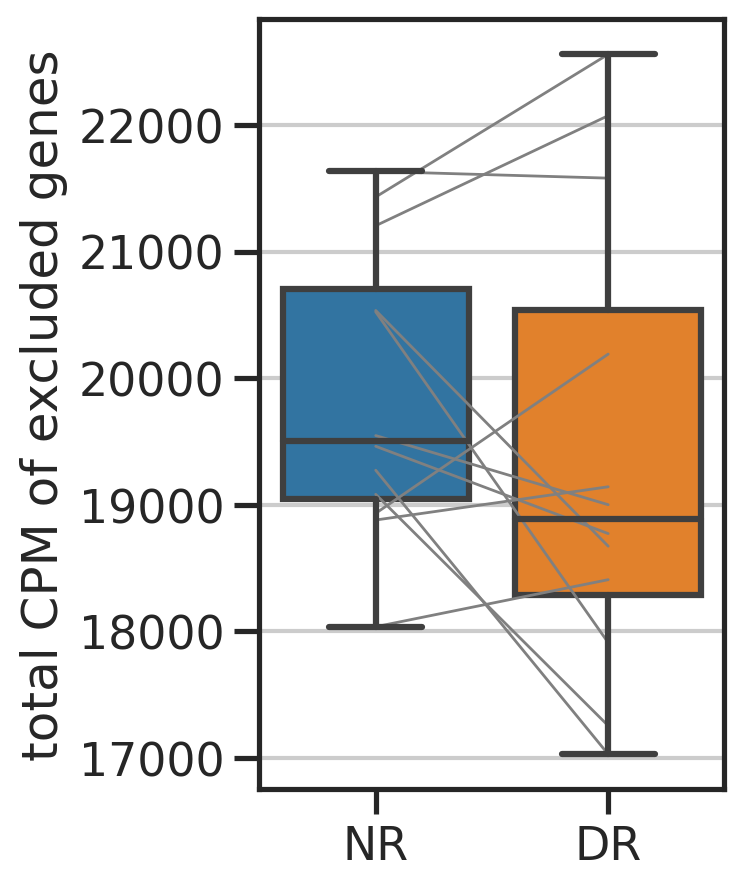

In [16]:
idx = np.arange(len(genes))[~expressed_any]
tensor_nr_ctrl = pbulks[0].T[idx]
tensor_dr_ctrl = pbulks[1].T[idx]

a = np.sum(np.power(10, tensor_nr_ctrl)-1, axis=0).ravel()
b = np.sum(np.power(10, tensor_dr_ctrl)-1, axis=0).ravel()

fig, ax = plt.subplots(figsize=(3,5))
for ai, bi in zip(a,b):
    ax.plot([0,1], [ai,bi], '-', color='gray', linewidth=1, markersize=1)
sns.boxplot([a,b], ax=ax)
ax.set_ylabel('total CPM of excluded genes')
ax.set_xticklabels(['NR', 'DR'])
plt.show()

# Do the tests

In [17]:
# test for each gene and cell type; 4 rep vs 4 rep - t-test and p-val correction 
ts, ps = ttest_ind(tensor_nr, tensor_dr, axis=2)
rs, qs, _, _ = multipletests(np.nan_to_num(ps, nan=1).reshape(-1,), method='fdr_bh')
rs = rs.reshape(ps.shape)
qs = qs.reshape(ps.shape)

# effect size
lfc = np.log2(10)*(np.mean(tensor_dr, axis=2) - np.mean(tensor_nr, axis=2)) # log2FC (log10CPM as raw counts)
# higherexp = np.maximum(np.mean(tensor_dr, axis=2), np.mean(tensor_nr, axis=2)) # mean exp for every gene type pair in the higher expressed condition

# why -- not expressed
i, j = np.where(np.isnan(ps))
np.isnan(ps).sum(), np.sum(tensor_nr[i,j]), np.sum(tensor_dr[i,j])

(0, 0.0, 0.0)

In [18]:
fc_threshold = 2
cond1   = rs # FDR< 0.05
cond2   = np.abs(lfc) >  np.log2(fc_threshold) 
cond2up = lfc         >  np.log2(fc_threshold) 
cond2dn = lfc         < -np.log2(fc_threshold) 

sde    = np.all([cond1, cond2],   axis=0)
sde_up = np.all([cond1, cond2up], axis=0)
sde_dn = np.all([cond1, cond2dn], axis=0)

sigsum = pd.DataFrame(index=unq_types)
sigsum['rej']   = np.sum(rs, axis=0)
sigsum['DE']    = np.sum(sde, axis=0)
sigsum['DR_up'] = np.sum(sde_up, axis=0)
sigsum['DR_dn'] = np.sum(sde_dn, axis=0)
sigsum

,rej,DE,DR_up,DR_dn
L5IT,305,48,37,11
L6IT_A,677,121,106,15
L6IT_B,75,14,13,1


In [19]:
res = pd.DataFrame()
gi_up, ti_up = sde_up.nonzero()
gi_dn, ti_dn = sde_dn.nonzero()
res['gene'] = genes_comm[np.hstack([gi_up, gi_dn])]
res['type'] = unq_types[np.hstack([ti_up, ti_dn])]
res['reason'] = ['DRup']*len(gi_up) + ['DRdn']*len(gi_dn)

# res.to_csv(os.path.join(outdir, 'DEGs_NRvsDR_P28P38_April11.csv'), header=True, index=False)
res

,gene,type,reason
0,Prim2,L6IT_A,DRup
1,Coq10b,L6IT_A,DRup
2,Zdbf2,L5IT,DRup
3,Zdbf2,L6IT_A,DRup
4,Btg2,L5IT,DRup
...,...,...,...
178,Mlh1,L6IT_B,DRdn
179,Arhgef15,L6IT_A,DRdn
180,Mei1,L5IT,DRdn
181,Mei1,L6IT_A,DRdn


In [20]:
res.groupby(['type', 'reason']).size().unstack().fillna(0).astype(int) #.value_counts()

reason,DRdn,DRup
type,,
L5IT,11,37
L6IT_A,15,106
L6IT_B,1,13


In [21]:
res['gene'].unique().shape

(152,)

In [22]:
def num_up(reasons):
    return np.sum(reasons == 'DRup')

def num_dn(reasons):
    return np.sum(reasons == 'DRdn')
    
def overall(reasons):
    a = num_up(reasons)
    b = num_dn(reasons)
    
    if a == 0 and b > 0:
        return 'DR_dn'
    elif b == 0 and a > 0:
        return 'DR_up'
    elif a > 0 and b > 0:
        return 'DR_updn'

resflat = res.groupby('gene').agg({'reason': (num_up, num_dn, overall)})['reason'] #  'reason': get_num_dn})
resflat

,num_up,num_dn,overall
gene,,,
1700016P03Rik,2,0,DR_up
4921539H07Rik,0,1,DR_dn
A430010J10Rik,0,1,DR_dn
AI115009,0,1,DR_dn
Acss1,1,0,DR_up
...,...,...,...
Tspan31,1,0,DR_up
Ttc28,1,0,DR_up
Tulp4,1,0,DR_up


In [23]:
# resflat.to_csv('/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/DR_DEGs_240708.csv')

# show results

In [24]:
def show_onetype(idx, columns=["NR_1", "NR_2", "NR_3", "NR_4", 
                               "DR_1", "DR_2", "DR_3", "DR_4",
                              ]):
    """idx - cell type idx
    """
    gidx = np.logical_or(sde_up[:,idx], sde_dn[:,idx])
    _genes = genes_comm[gidx]

    p_nr = tensor_nr[gidx,:,:][:,idx,:]
    p_dr = tensor_dr[gidx,:,:][:,idx,:]
    
    
    ab = np.hstack([p_nr, p_dr])
    nr_mean = np.mean(p_nr, axis=1)
    ab = (ab - nr_mean.reshape(-1,1))*np.log2(10) # log2 FC w.r.t. the mean in NR
    ab = pd.DataFrame(ab, index=_genes, columns=columns)
    
    this_mlfc = (np.mean(p_nr, axis=1) - np.mean(p_dr, axis=1))*np.log2(10)
    this_ordr = np.argsort(this_mlfc)
    ab = ab.iloc[this_ordr]
    
    fig, ax = plt.subplots(figsize=(4, min(10, 0.3*len(ab))))
    sns.heatmap(ab, center=0, cmap='coolwarm', yticklabels=True, cbar_kws=dict(shrink=0.5, label='log2 FC (w.r.t. NR mean)'))
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title(unq_types[idx])
    plt.show()

In [25]:
def show_volcano(thetypeidx, thetype, lfc, qs, cond1, cond2up, cond2dn, ax=None, bbox_to_anchor=(1,1), loc=None):
    """
    Gene by type matrices: 
        lfc matrix: log fold change
        qs matirx:
    
        cond1 : significant or not? 
        cond2up: FC above the cutoff?
        cond2dn: FC below the cutoff?
    
    thetypeidx: pick a type - one column index from the above matrices
    """
    eff = lfc[:,thetypeidx]
    pvl =  qs[:,thetypeidx]

    cnd_up = np.all([cond1[:,thetypeidx], 
                     cond2up[:,thetypeidx]], axis=0) 
    cnd_dn = np.all([cond1[:,thetypeidx], 
                     cond2dn[:,thetypeidx]], axis=0) 

    if ax is None:
        fig, ax = plt.subplots()
    else:
        pass
    ax.scatter(eff, -np.log10(pvl), s=1, color='gray')

    ax.scatter(eff[cnd_up], -np.log10(pvl)[cnd_up], s=5, #s=5, 
               label=f'DR up (n={cnd_up.sum():,})')
    ax.scatter(eff[cnd_dn], -np.log10(pvl)[cnd_dn], s=5, #s=5, 
               label=f'DR dn (n={cnd_dn.sum():,})')

    ax.set_xlabel('log2(FC) (DR/NR in CPM)')
    ax.set_ylabel('-log10(FDR)')
    ax.set_title(f'{thetype}')
    ax.legend(bbox_to_anchor=bbox_to_anchor, loc=loc)
    return ax

In [26]:
types_order = [
    'L6IT_A', 
    'L6IT_B', 
    'L5IT', 
]
len(types_order)

3

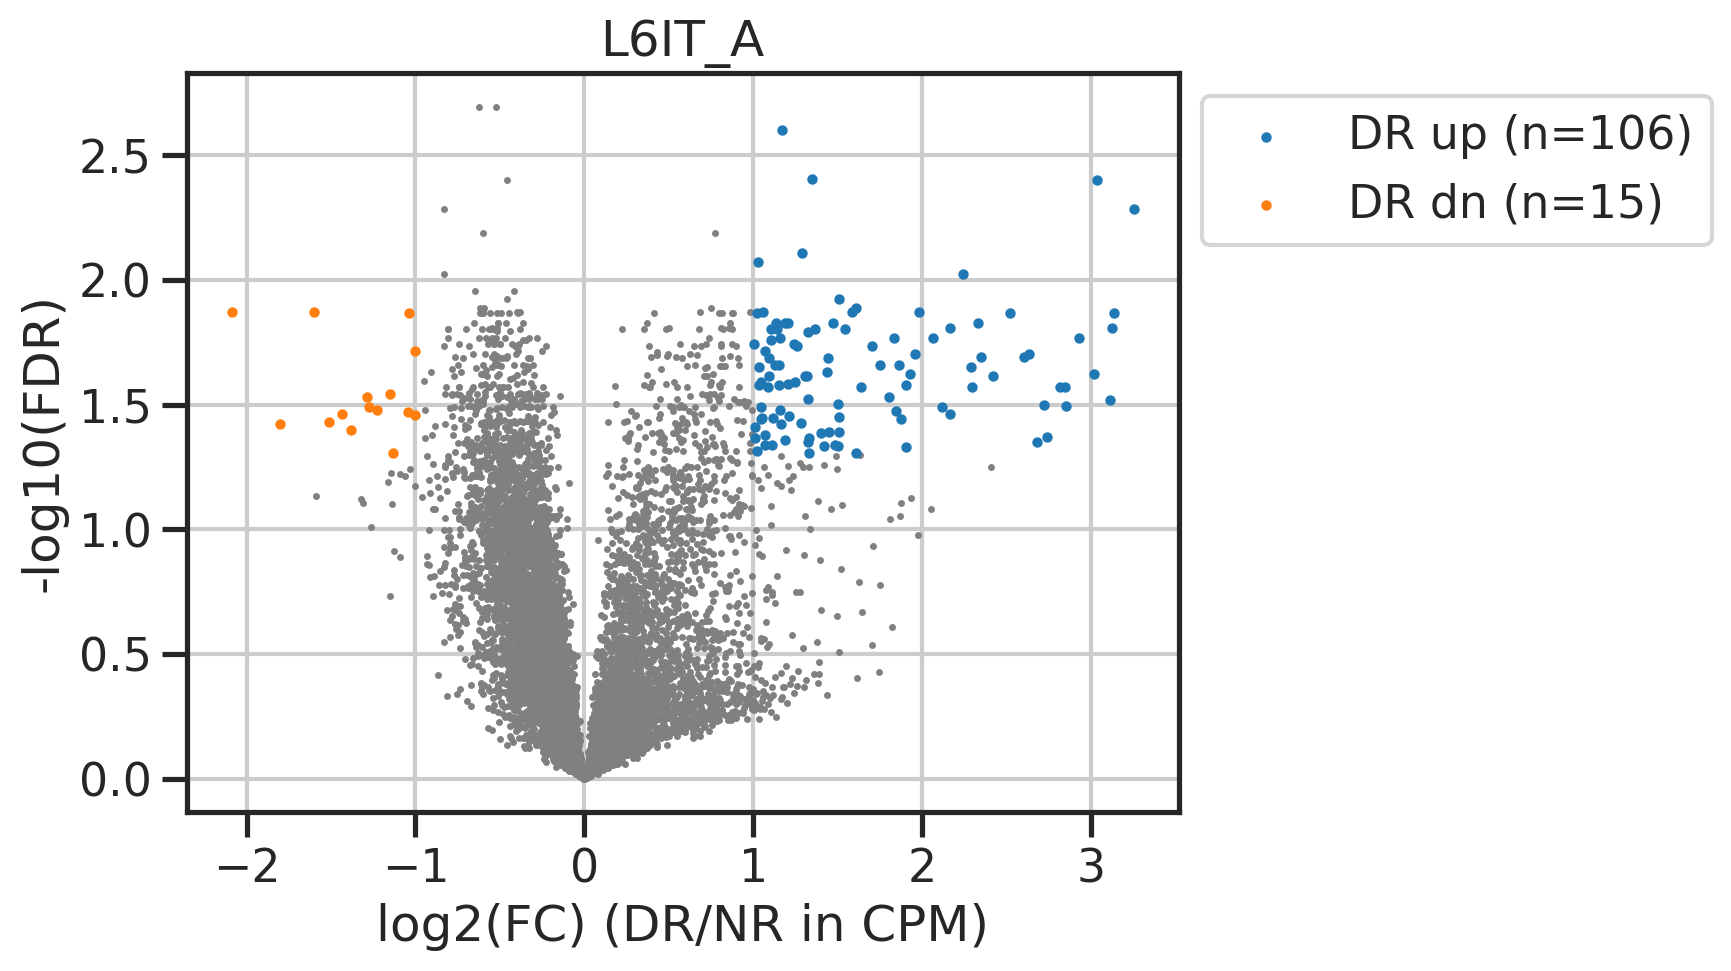

In [27]:
thetype = 'L6IT_A'
thetypeidx = basicu.get_index_from_array(unq_types, [thetype])[0]
assert thetypeidx != -1
show_volcano(thetypeidx, thetype, lfc, qs, cond1, cond2up, cond2dn) 
plt.show()

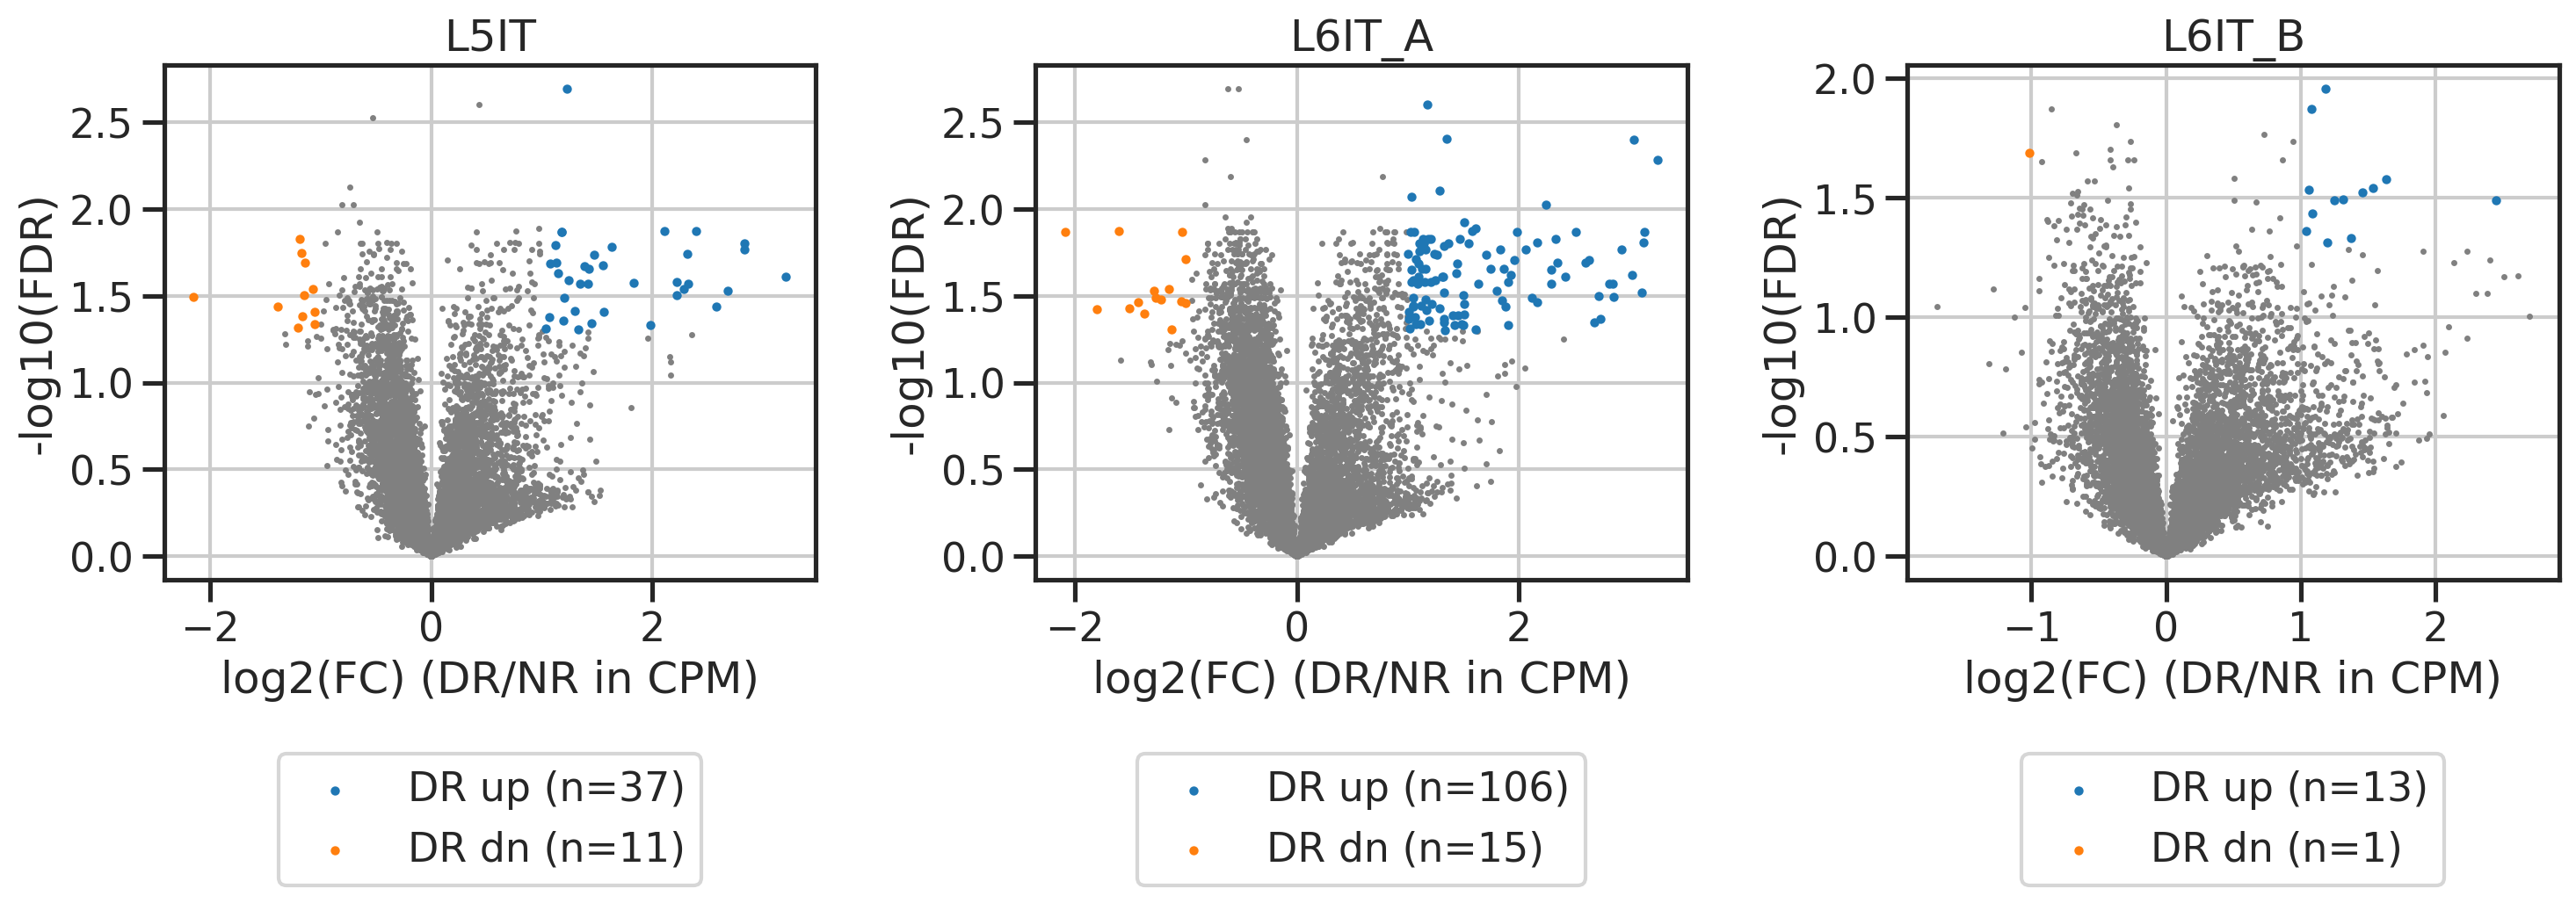

In [28]:
fig, axs = plt.subplots(1,3,figsize=(5*3,6*1))
for thetypeidx, thetype in enumerate(unq_types):
    assert thetypeidx != -1
    ax = axs.flat[thetypeidx]
    show_volcano(thetypeidx, thetype, lfc, qs, cond1, cond2up, cond2dn, ax=ax, bbox_to_anchor=(0.5, -0.3), loc='upper center') 
fig.tight_layout()
plt.show()

In [29]:
sigsum

,rej,DE,DR_up,DR_dn
L5IT,305,48,37,11
L6IT_A,677,121,106,15
L6IT_B,75,14,13,1


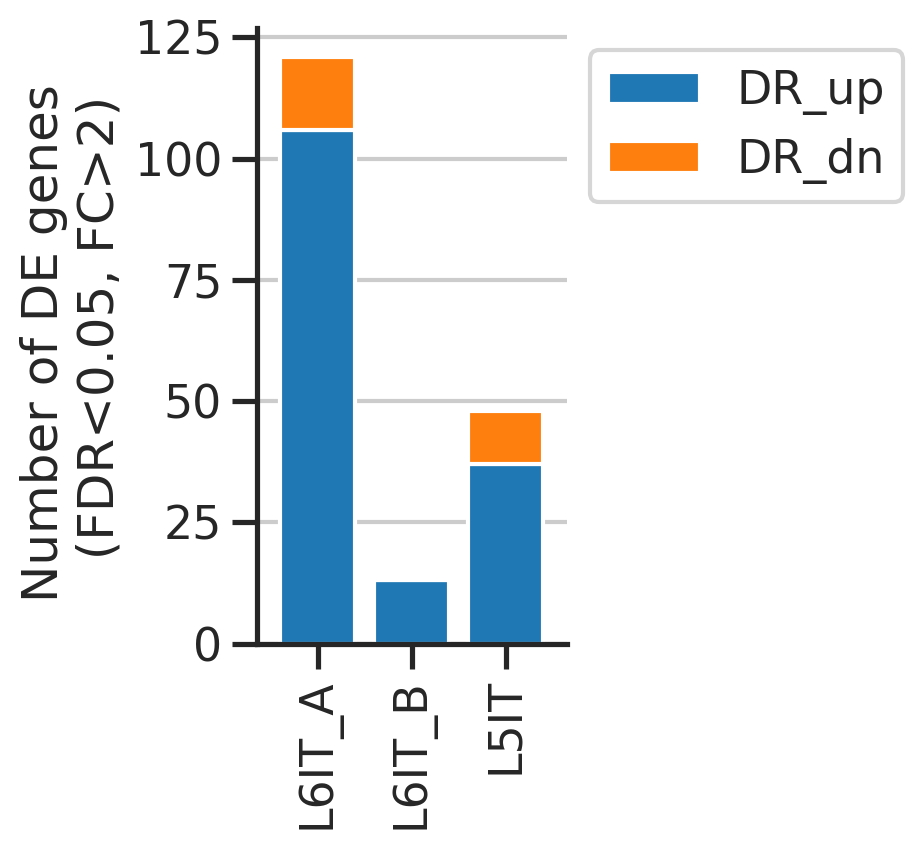

In [30]:
fig, ax = plt.subplots(figsize=(2,4))
sigsum.loc[types_order][['DR_up', 'DR_dn']].plot.bar(stacked=True, width=0.8, ax=ax)
ax.set_ylabel('Number of DE genes \n (FDR<0.05, FC>2)')

ax.legend(bbox_to_anchor=(1,1))
sns.despine(ax=ax)
ax.grid(axis='x')

# output = os.path.join(outfigdir, "bar.pdf")
# powerplots.savefig_autodate(fig, output)
plt.show()

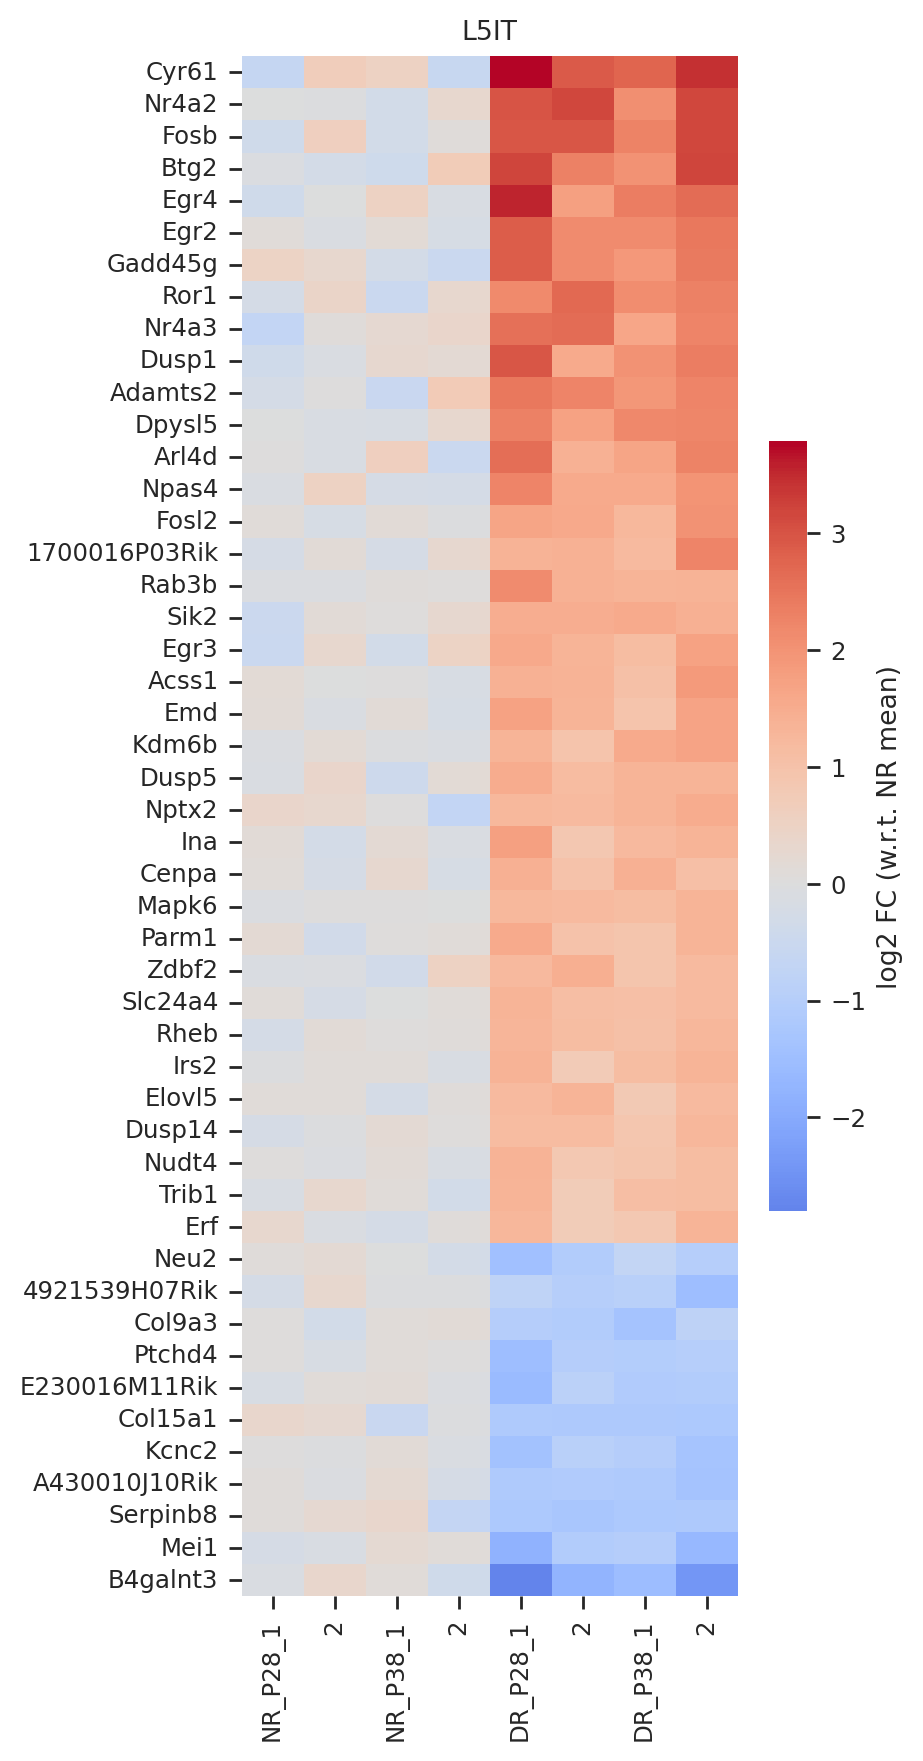

In [31]:
columns = [
    'NR_P28_1', '2', 'NR_P38_1', '2',
    'DR_P28_1', '2', 'DR_P38_1', '2',
]
with sns.plotting_context('paper'):
    for i, (_type, row) in enumerate(sigsum.iterrows()):
        if row['DE'] > 0:
            show_onetype(i, columns=columns)
        break

# Check a few genes and see

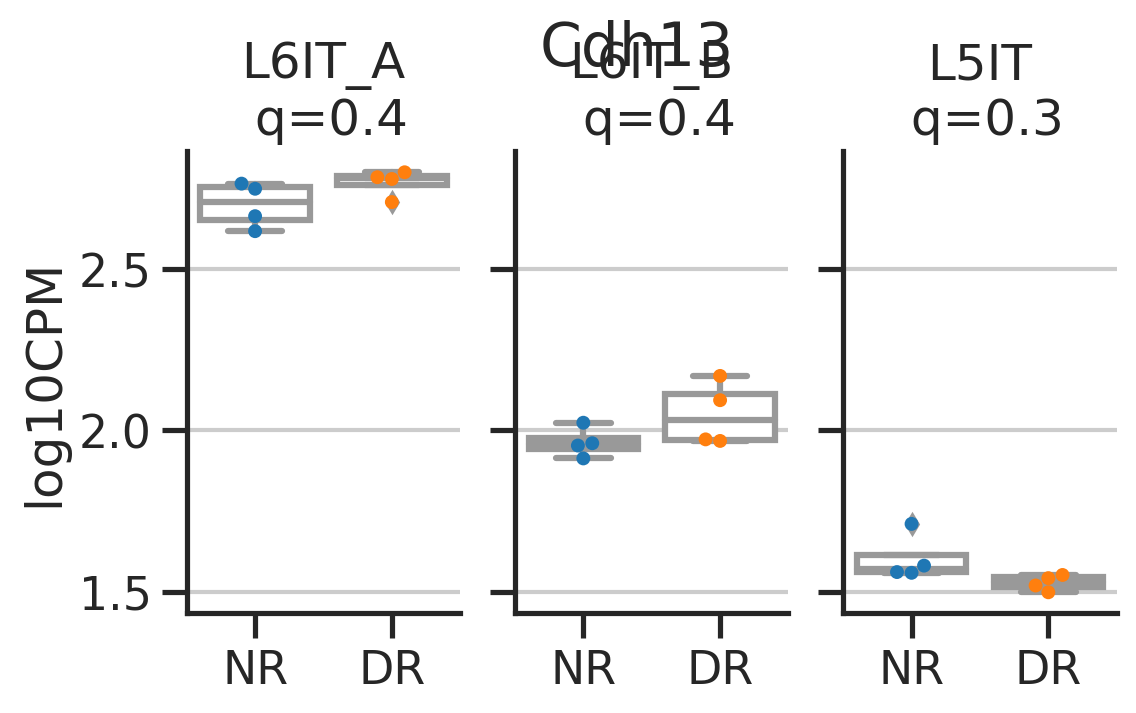

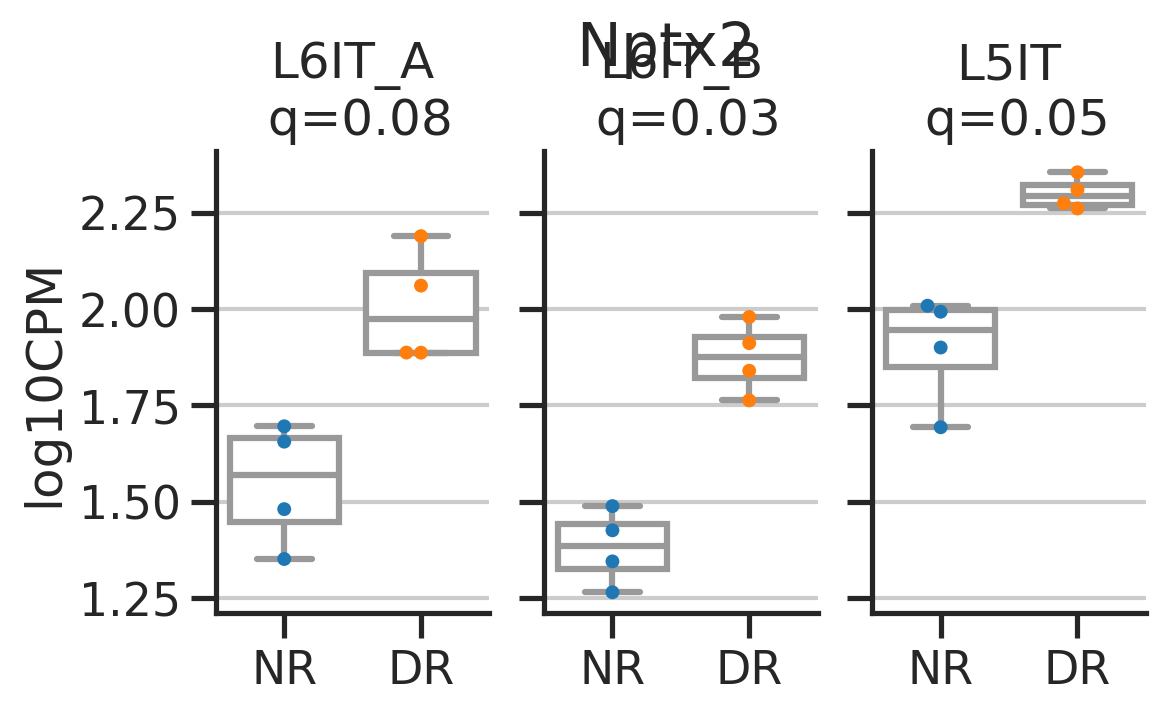

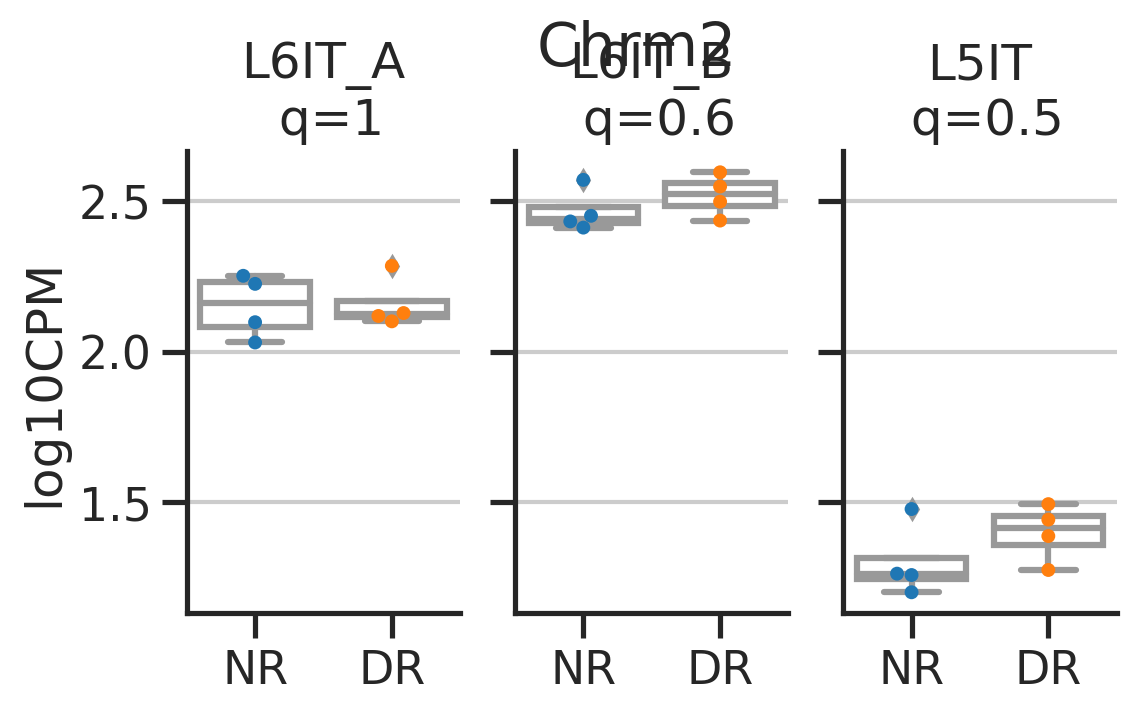

In [32]:
for gene_name in ['Cdh13', 'Nptx2', 'Chrm2']: #['Col19a1', 'Nr4a2', 'Fosb']:
    fig, axs = plt.subplots(1,3,figsize=(2*3,3), sharey=True)
    fig.suptitle(gene_name, y=1.1)
    for type_name, ax in zip(['L6IT_A', 'L6IT_B', 'L5IT'], axs):
        gidx = basicu.get_index_from_array(genes, [gene_name])[0]
        gidx2 = basicu.get_index_from_array(genes_comm, [gene_name])[0]
        cidx = basicu.get_index_from_array(unq_types, [type_name])[0]
        p_nr, p_dr = pbulks[:,:,:,gidx][:,:,cidx]
        assert gidx != -1
        assert cidx != -1

        sns.boxplot  ([p_nr, p_dr], color='white', ax=ax)
        sns.swarmplot([p_nr, p_dr], s=5, ax=ax)

        # check
        # l2fc2 = np.log2(10)*(np.mean(p_dr) - np.mean(p_nr))
        eff = lfc[gidx2, cidx]
        q   = qs[gidx2, cidx]
        sns.despine(ax=ax)

        ax.set_xticklabels(['NR', 'DR'])
        ax.set_ylabel('log10CPM')
        ax.set_title(f'{type_name}\n q={q:.1g}')
    plt.show()

# a plot of those unique genes across all cell types

In [33]:
from scipy.stats import zscore

In [34]:
degs = np.unique(res['gene'])
degs_idx = basicu.get_index_from_array(genes, degs)

row = degs
col = unq_types

In [35]:
a = pbulks[:,:,:,degs_idx].T
a = np.swapaxes(a,2,3)
a0,a1,a2,a3 = a.shape # gene, type, cond, rep
am = zscore(np.mean(a, axis=(2,3)), axis=1)
af = zscore(a.reshape(a0, a1*a2*a3), axis=1)


rowidx = np.array(basicu.order_by_hc(af))
colidx = np.array(basicu.order_by_hc(am.T))
# colidx = basicu.get_index_from_array(xclsts_sel, types_order)
colidx_expanded = np.ravel(a2*a3*colidx.reshape(-1,1) + np.repeat(np.arange(a2*a3).reshape(1,-1), len(colidx), axis=0))

In [36]:
nr_mean = np.mean(a, axis=3)[:,:,0]
a_lfc = np.log2(10)*(a-nr_mean.reshape(a0,a1,1,1))
af_lfc = a_lfc.reshape(a0, a1*a2*a3)

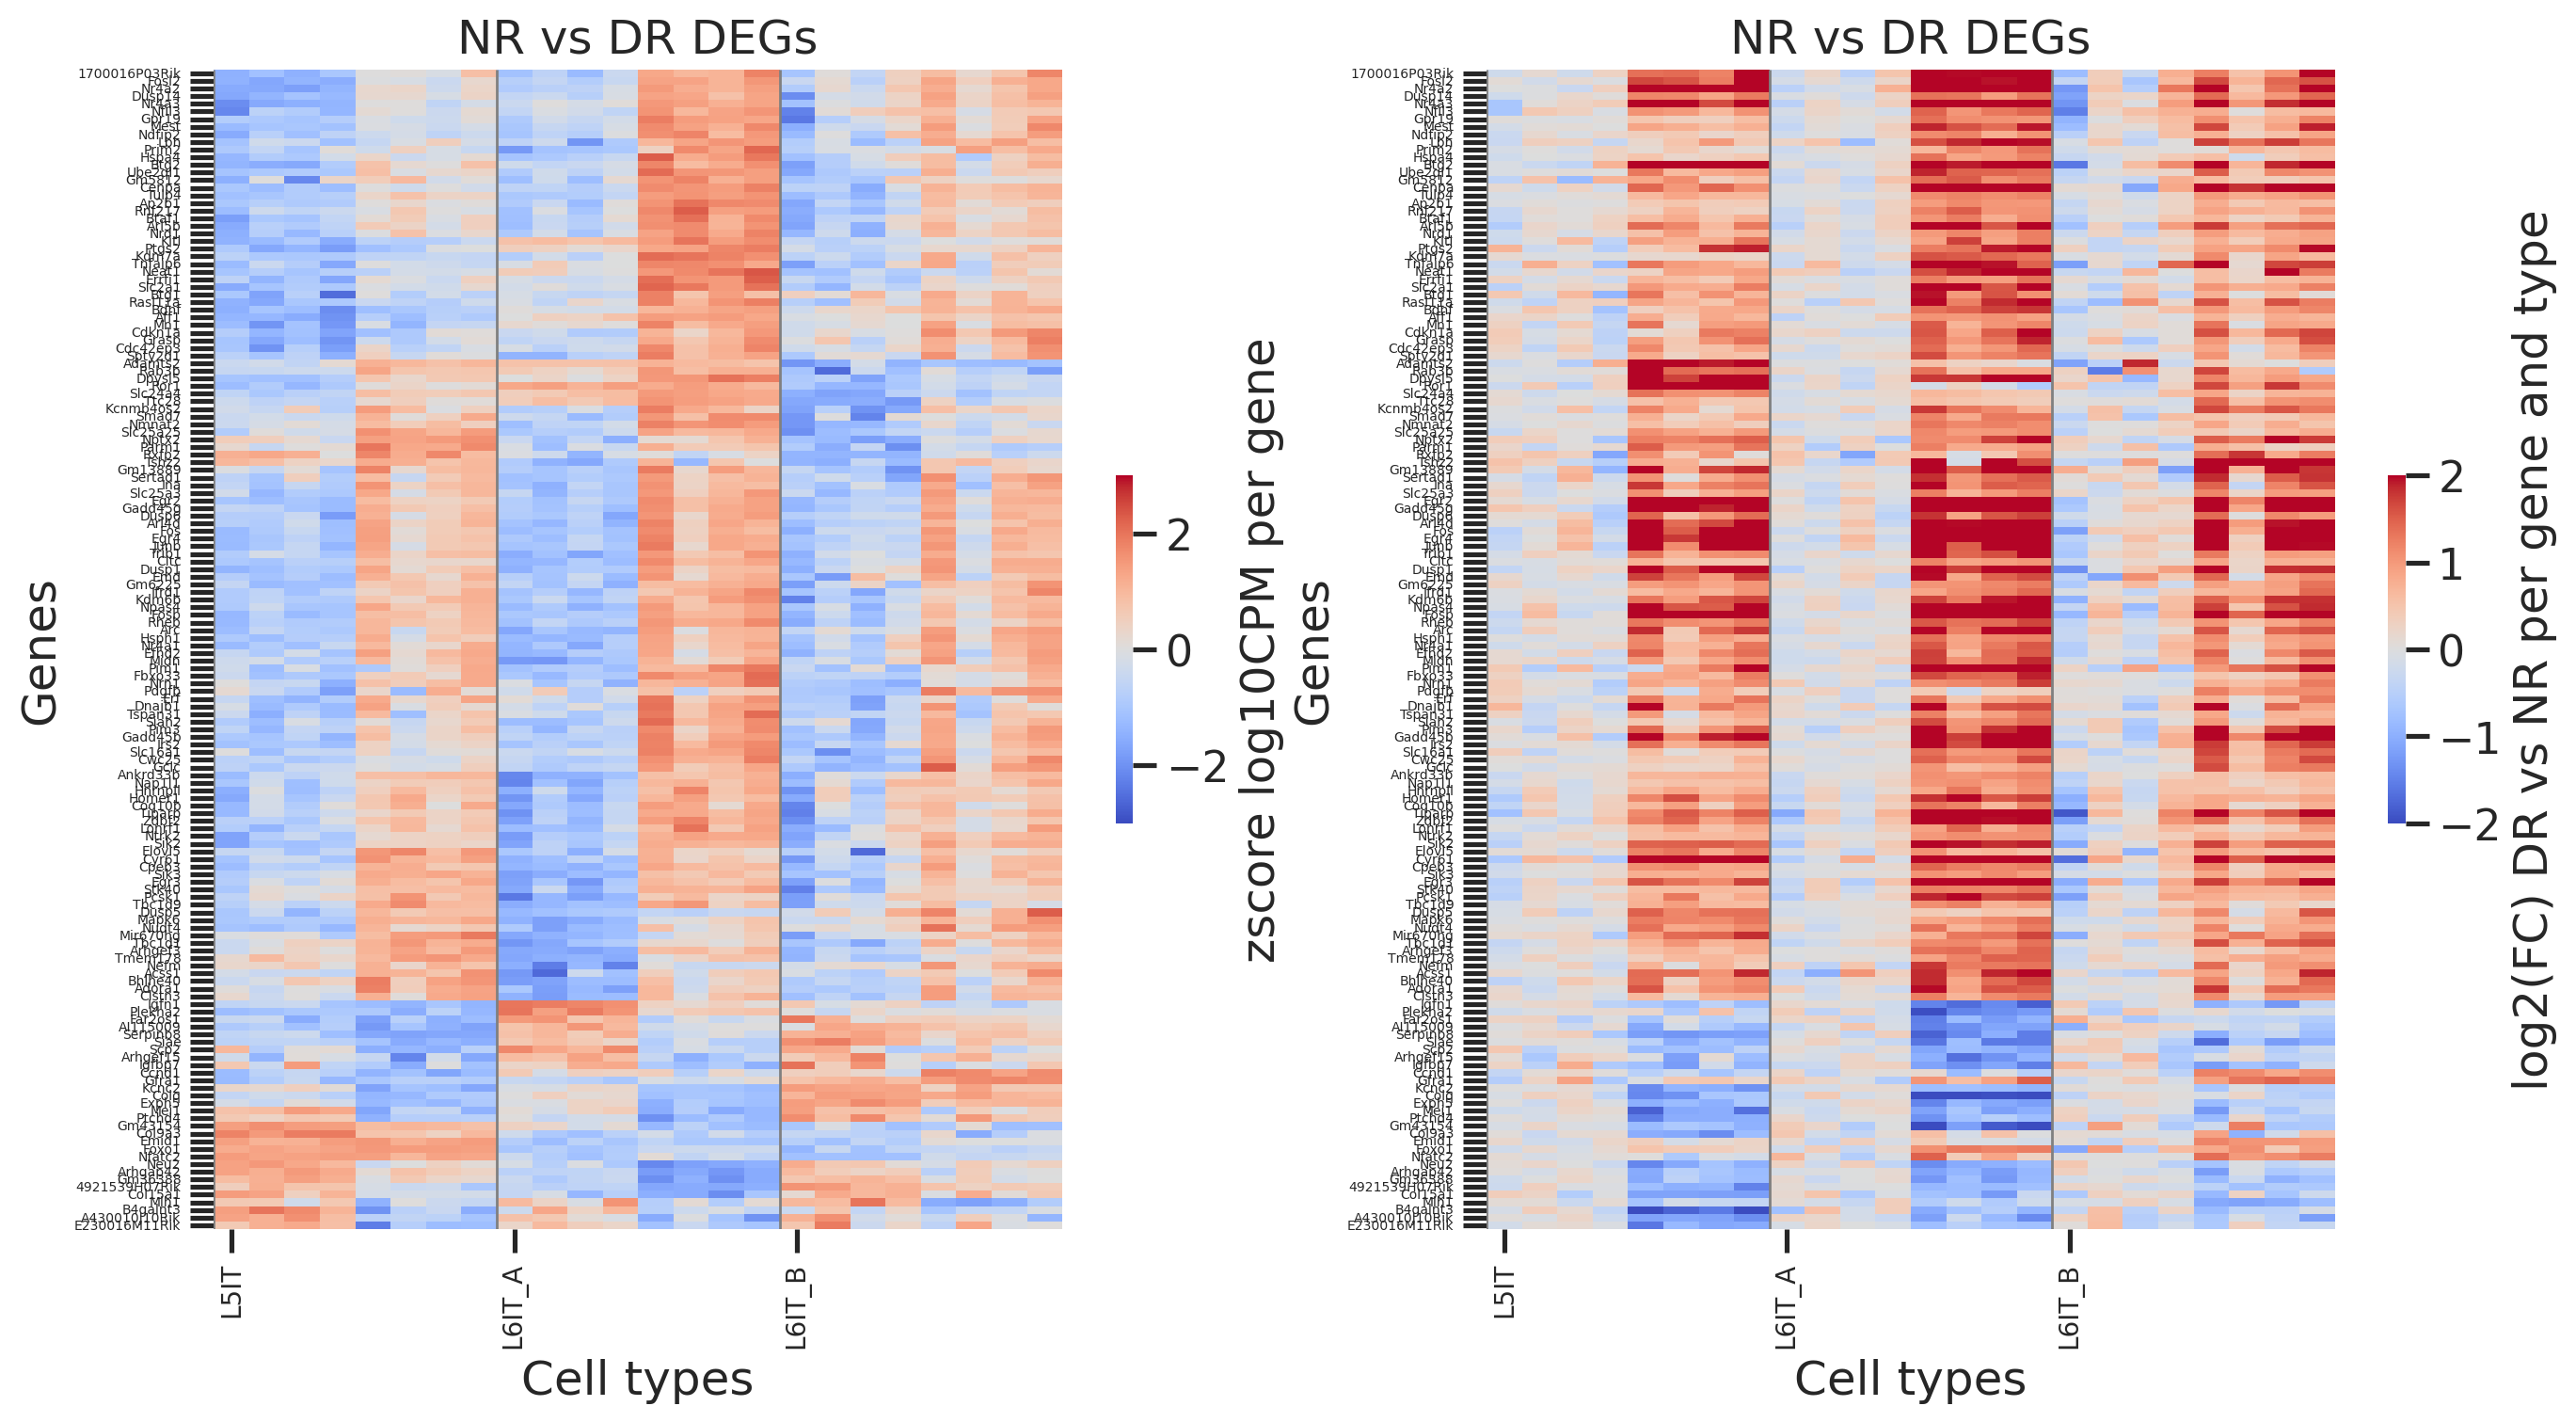

In [37]:
fig, axs = plt.subplots(1,2,figsize=(8*2,8))
ax = axs[0]
sns.heatmap(af[rowidx][:,colidx_expanded], 
            yticklabels=True,
            xticklabels=a2*a3,
            cbar_kws=dict(shrink=0.3, label='zscore log10CPM per gene'),
            cmap='coolwarm', 
            center=0, vmin=-3, vmax=3,
            ax=ax) 
ax.vlines(np.arange(0, a1*a2*a3, a2*a3), 0, a0, color='gray', linewidth=1)
ax.set_xticklabels(col[colidx], rotation=90, fontsize=10)
ax.set_yticklabels(row[rowidx], rotation=0, fontsize=5)
ax.set_ylabel('Genes')
ax.set_xlabel('Cell types')
ax.set_title('NR vs DR DEGs')

ax = axs[1]
sns.heatmap(af_lfc[rowidx][:,colidx_expanded], 
            yticklabels=True, # 20, #degs[rowidx],
            xticklabels=a2*a3,
            cbar_kws=dict(shrink=0.3, label='log2(FC) DR vs NR per gene and type'),
            cmap='coolwarm', 
            center=0, vmin=-2, vmax=2,
            ax=ax) 
ax.vlines(np.arange(0, a1*a2*a3, a2*a3), 0, a0, color='gray', linewidth=1)
ax.set_xticklabels(col[colidx], rotation=90, fontsize=10)
ax.set_yticklabels(row[rowidx], rotation=0, fontsize=5)
ax.set_ylabel('Genes')
ax.set_xlabel('Cell types')
ax.set_title('NR vs DR DEGs')
plt.show()

# overlap with type genes

In [38]:
def num_up(reasons):
    return np.sum(reasons == 'DRup')

def num_dn(reasons):
    return np.sum(reasons == 'DRdn')
    
def overall(reasons):
    a = num_up(reasons)
    b = num_dn(reasons)
    
    if a == 0 and b > 0:
        return 'DR_dn'
    elif b == 0 and a > 0:
        return 'DR_up'
    elif a > 0 and b > 0:
        return 'DR_updn'

resflat = res.groupby('gene').agg({'reason': (num_up, num_dn, overall)})['reason'] #  'reason': get_num_dn})
resflat

,num_up,num_dn,overall
gene,,,
1700016P03Rik,2,0,DR_up
4921539H07Rik,0,1,DR_dn
A430010J10Rik,0,1,DR_dn
AI115009,0,1,DR_dn
Acss1,1,0,DR_up
...,...,...,...
Tspan31,1,0,DR_up
Ttc28,1,0,DR_up
Tulp4,1,0,DR_up


In [39]:
cond_overlap1 = (
         (resflat['num_up'] != 0) & 
         (resflat['num_dn'] != 0)
       )
cond_overlap2 = (
         (resflat['num_up'] != 0) & 
         (resflat['num_dn'] == 0)
       )
cond_overlap3 = (
         (resflat['num_up'] == 0) & 
         (resflat['num_dn'] != 0)
       )

# resflat[cond_overlap1]
print("up and down", cond_overlap1.sum())
print("up only", cond_overlap2.sum())
print("down only", cond_overlap3.sum())

up and down 0
up only 127
down only 25


In [40]:
# f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv'
# fout = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot_v3_july8_2024.csv'

# df2 = pd.read_csv(f)
# df2['DR_DE'] = df2['gene'].apply(lambda x: x in degs) 
# df2 = pd.merge(df2, resflat['overall'].rename('DR_updn'), left_on='gene', right_index=True, how='left')
# df2.to_csv(fout, header=True, index=False)
# df2

In [69]:
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/res/L56-ABC-genes-n602unq-annot.csv' # L23-ABC-genes-n288-n286unq-annot_v3_july8_2024.csv'
df2 = pd.read_csv(f)
df2

,gene,group
0,Ldlr,A
1,Snta1,A
2,Smarca2,A
3,Slit3,A
4,Gm11417,A
...,...,...
597,Hs3st2,C
598,Homer2,C
599,Hjurp,C
600,Grm3,C


In [70]:
typegenes = df2['gene'].values
degs_up = resflat[resflat['overall']=='DR_up'].index.values
degs_dn = resflat[resflat['overall']=='DR_dn'].index.values
df2['DR_DE'] = [g in detgs for g in df2['gene']]

detgs = np.intersect1d(degs, typegenes)
detgs_up = np.intersect1d(degs_up, typegenes)
detgs_dn = np.intersect1d(degs_dn, typegenes)
print(degs.shape, typegenes.shape, detgs.shape)
print(detgs.shape, detgs_up.shape, detgs_dn.shape)
detgs, detgs_up, detgs_dn

(152,) (602,) (25,)
(25,) (15,) (10,)


(array(['4921539H07Rik', 'Adamts2', 'Arhgap42', 'Col15a1', 'Egr3', 'Exph5',
        'Foxo1', 'Gm36388', 'Gm43154', 'Grasp', 'Kcnc2', 'Kitl',
        'Mir670hg', 'Nefm', 'Neu2', 'Nptx2', 'Nr4a2', 'Nr4a3', 'Pcsk1',
        'Ptchd4', 'Siae', 'Slc24a4', 'Tbc1d1', 'Tmem178', 'Ttc28'],
       dtype=object),
 array(['Adamts2', 'Egr3', 'Foxo1', 'Grasp', 'Kitl', 'Mir670hg', 'Nefm',
        'Nptx2', 'Nr4a2', 'Nr4a3', 'Pcsk1', 'Slc24a4', 'Tbc1d1', 'Tmem178',
        'Ttc28'], dtype=object),
 array(['4921539H07Rik', 'Arhgap42', 'Col15a1', 'Exph5', 'Gm36388',
        'Gm43154', 'Kcnc2', 'Neu2', 'Ptchd4', 'Siae'], dtype=object))

In [71]:
dfplot = pd.merge(resflat['overall'].rename('DR'), df2.set_index('gene')['group'].rename('type'), 
                  left_index=True, right_index=True, how='outer')
dfplot['isType']= ~pd.isna(dfplot['type'])
dfplot['isDR']  = ~pd.isna(dfplot['DR'])
dfplot['DR_up'] = dfplot['DR'].apply(lambda x: x == 'DR_up') 
dfplot['DR_dn'] = dfplot['DR'].apply(lambda x: x == 'DR_dn') 
dfplot

,DR,type,isType,isDR,DR_up,DR_dn
gene,,,,,,
1190002N15Rik,NaN,C,True,False,False,False
1700016P03Rik,DR_up,NaN,False,True,True,False
1700023F02Rik,NaN,A,True,False,False,False
1810041L15Rik,NaN,C,True,False,False,False
2510009E07Rik,NaN,C,True,False,False,False
...,...,...,...,...,...,...
Zfp804a,NaN,AB,True,False,False,False
Zfp804b,NaN,A,True,False,False,False
Zfp831,NaN,A,True,False,False,False


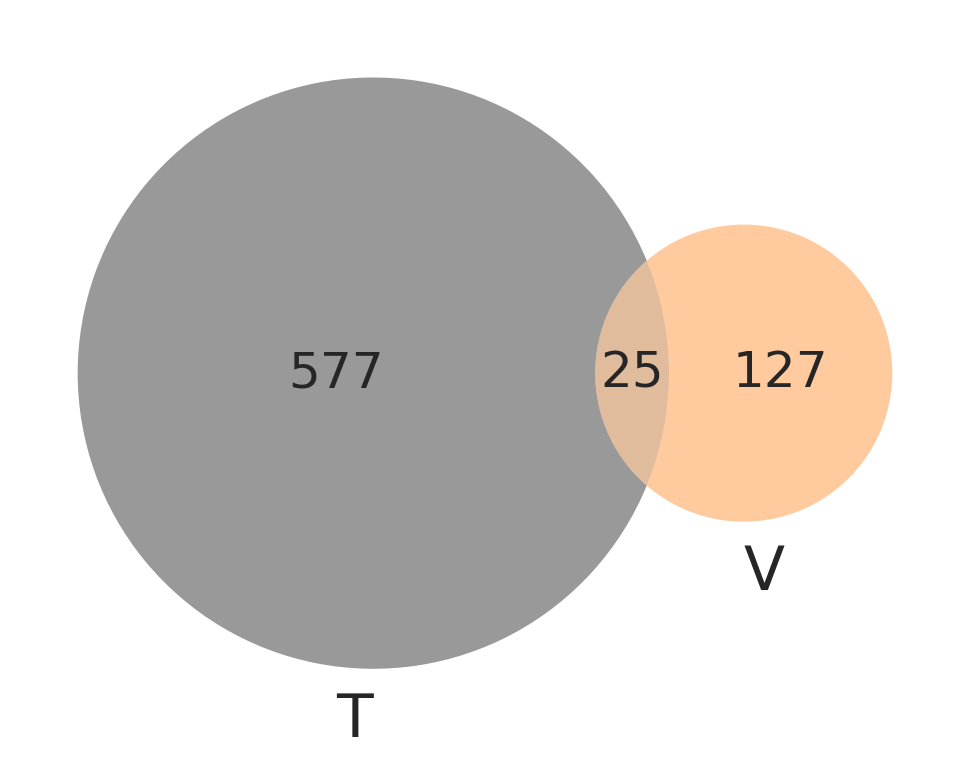

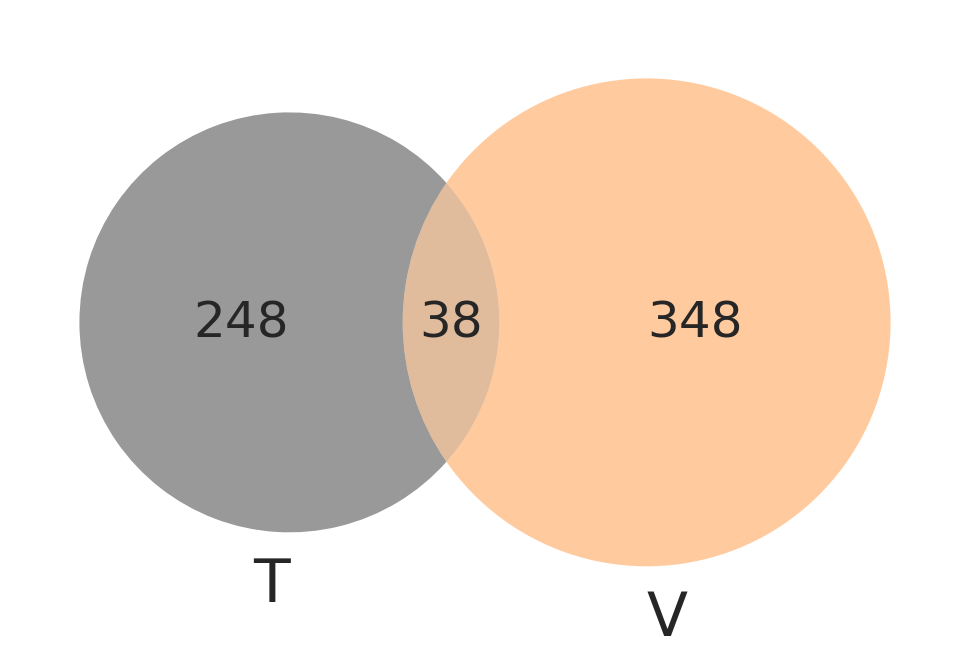

In [72]:
from matplotlib_venn import venn2

a = dfplot[dfplot['isType']].index.values
b = dfplot[dfplot['isDR']].index.values

fig, ax = plt.subplots(1,1,figsize=(1*6,1*5))
venn2([set(a.tolist()), set(b.tolist())], 
      set_labels=('T', 'V'), 
      set_colors=('k', 'C1'),
      normalize_to=1.0,
      ax=ax,
     )

fig, ax = plt.subplots(1,1,figsize=(1*6,1*5))
venn2(subsets=(248, 348, 38), 
      set_labels=('T', 'V'), 
      set_colors=('k', 'C1'),
      normalize_to=1.0*(248+348+38)/(577+127+25),
      ax=ax,
     )
# output = os.path.join(outfigdir, "venn_diagram.pdf")
# powerplots.savefig_autodate(fig, output)
plt.show()

In [73]:
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/annot/Hrvatin17_ARGs.csv'
hr_args = pd.read_csv(f, skiprows=6, index_col=0) #[0].values
hr_iegs = hr_args[np.any(hr_args=='a', axis=1)]

hrl23_args = hr_args[~hr_args['ExcL23'].isnull()]
hrl23_iegs = hr_args[hr_args['ExcL23'].isin(['a', 'b'])]
hrl23_lrgs = hr_args[hr_args['ExcL23'].isin(['c', 'd'])]

print(len(hr_iegs))
print(len(hrl23_args))
print(len(hrl23_iegs))
print(len(hrl23_lrgs))

269
79
42
37


In [74]:
len(dfplot[dfplot['DR_dn']]), len(dfplot[dfplot['DR_up']])

(25, 127)

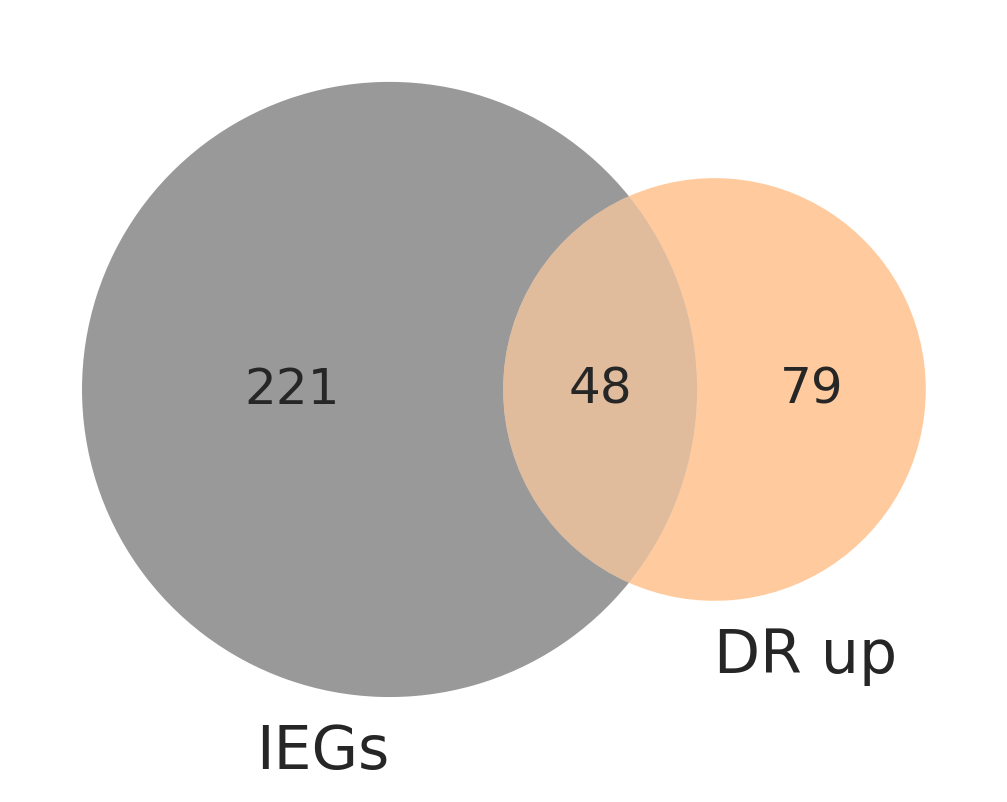

In [75]:
fig, ax = plt.subplots()
a = hr_iegs.index.values
b = dfplot[dfplot['DR_up']].index.values
venn2([set(a.tolist()), set(b.tolist())], 
      set_labels=('IEGs', 'DR up'), 
      set_colors=('k', 'C1'),
      ax=ax,
     )
# output = os.path.join(outfigdir, "venn_diagram.pdf")
# powerplots.savefig_autodate(fig, output)
plt.show()

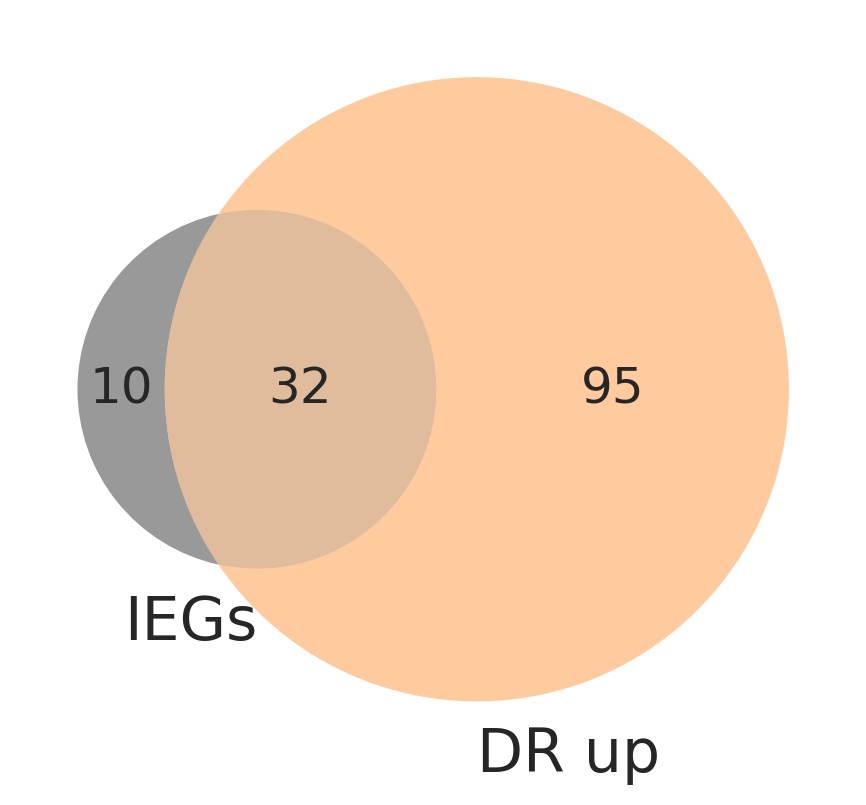

In [76]:
fig, ax = plt.subplots()
a = hrl23_iegs.index.values
b = dfplot[dfplot['DR_up']].index.values
venn2([set(a.tolist()), set(b.tolist())], 
      set_labels=('IEGs', 'DR up'), 
      set_colors=('k', 'C1'),
      ax=ax,
     )
# output = os.path.join(outfigdir, "venn_diagram.pdf")
# powerplots.savefig_autodate(fig, output)
plt.show()

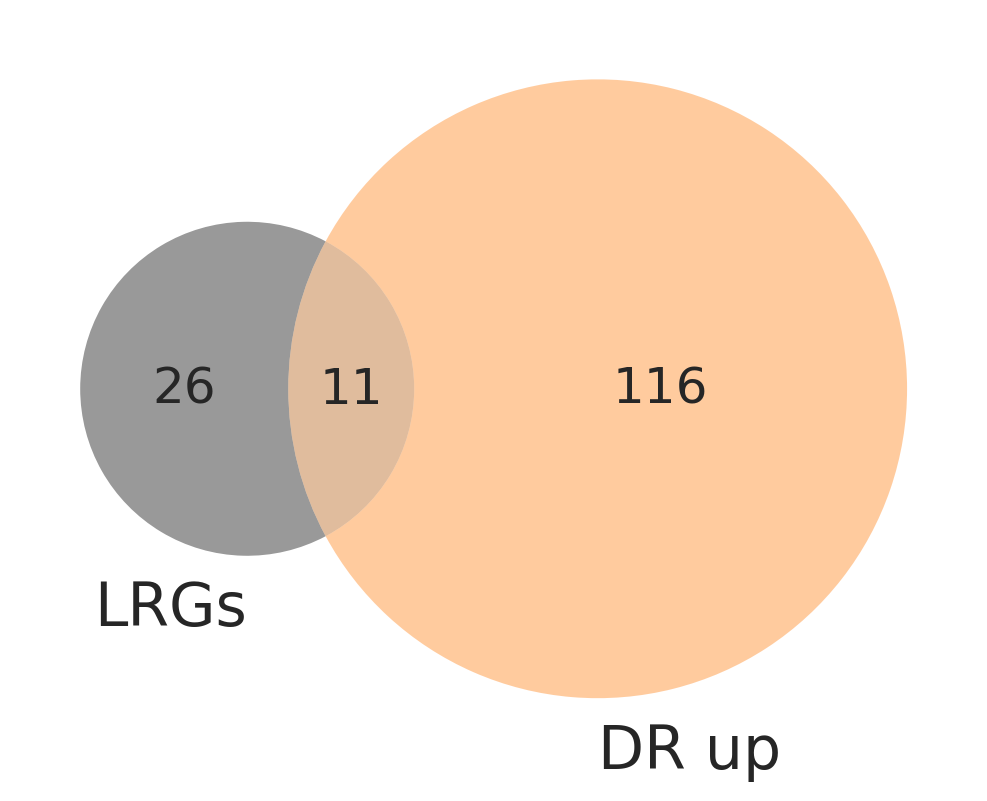

In [77]:
fig, ax = plt.subplots()
a = hrl23_lrgs.index.values
b = dfplot[dfplot['DR_up']].index.values
venn2([set(a.tolist()), set(b.tolist())], 
      set_labels=('LRGs', 'DR up'), 
      set_colors=('k', 'C1'),
      ax=ax,
     )
# output = os.path.join(outfigdir, "venn_diagram.pdf")
# powerplots.savefig_autodate(fig, output)
plt.show()

# how many of those 38 vision-dependent type-specific genes are DEGs in A, B, C?
- a bar plot

In [78]:
# res['gene'].unique().shape
# res.groupby(['type']).size()
# res_reduced.sort_values(['gene', 'type', 'reason']) #.apply(lambda x: x.join(','))

In [79]:
df_tv = dfplot[dfplot['isDR']&dfplot['isType']]
res_reduced = res[res['gene'].isin(df_tv.index.values)]  # .groupby(['type', 'reason']).size()
res_summary = res_reduced.groupby(['type', 'reason']).size()
# df_tv, res_reduced['gene'].unique().shape, res_summary

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/bar_2024-08-15.pdf


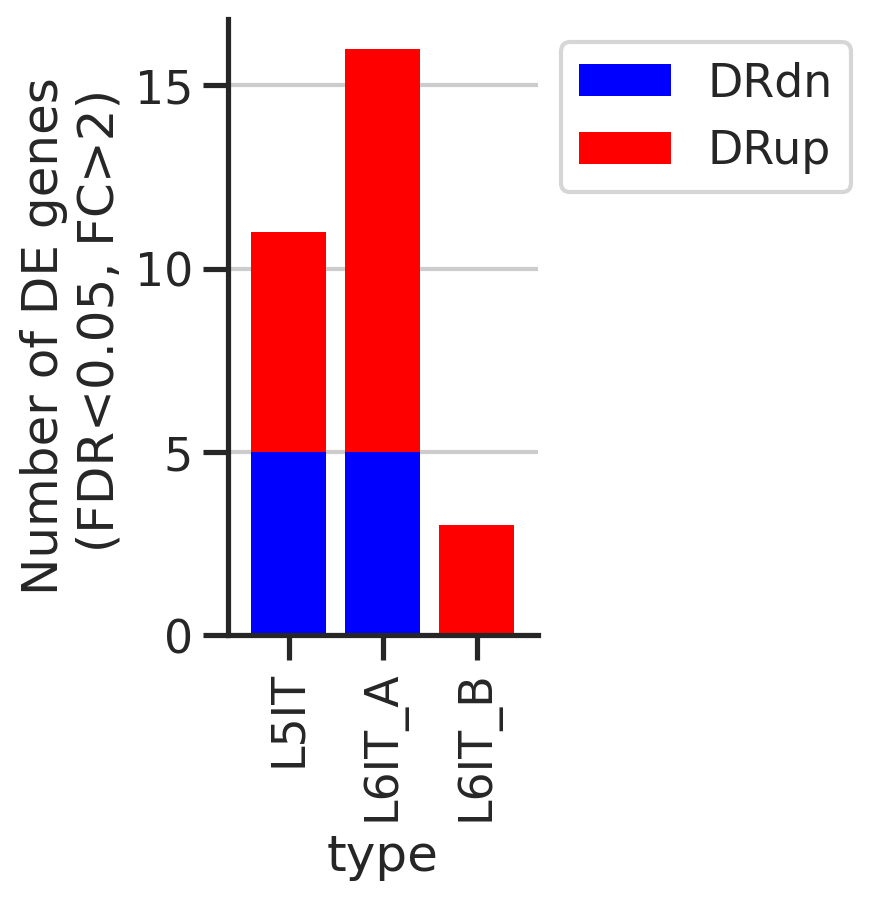

In [80]:
fig, ax = plt.subplots(figsize=(2,4))
res_summary.unstack().plot.bar(stacked=True, width=0.8, edgecolor='none', color=['b', 'r'], ax=ax)
ax.set_ylabel('Number of DE genes \n (FDR<0.05, FC>2)')

ax.legend(bbox_to_anchor=(1,1))
sns.despine(ax=ax)
ax.grid(axis='x')

output = os.path.join(outfigdir, "bar.pdf")
powerplots.savefig_autodate(fig, output)
plt.show()

# visualize those that goes up or down

In [81]:
from scipy.cluster import hierarchy as sch
import importlib
importlib.reload(basicu)

<module 'scroutines.basicu' from '/u/project/zipursky/f7xiesnm/code/scroutines/scroutines/basicu.py'>

In [82]:
def plot_3panels(a, row, col):
    """
    """
    a0,a1,a2,a3 = a.shape # gene, type, cond, rep
    am = zscore(np.mean(a, axis=(2,3)), axis=1)
    af = zscore(a.reshape(a0, a1*a2*a3), axis=1)

    gene_idx, gene_Z = basicu.order_by_hc(af, return_Z=True, method='average', metric='correlation')
    rowidx = np.array(gene_idx)
    colidx = np.array([0,1,2])

    colidx_expanded = np.ravel(a2*a3*colidx.reshape(-1,1) + np.repeat(np.arange(a2*a3).reshape(1,-1), len(colidx), axis=0))
    col_expanded = np.ravel(np.repeat(np.arange(a2*a3).reshape(1,-1), len(col), axis=0))

    nr_mean = np.mean(a, axis=3)[:,:,0]
    a_lfc = np.log2(10)*(a-nr_mean.reshape(a0,a1,1,1))
    af_lfc = a_lfc.reshape(a0, a1*a2*a3)
    
    fig, axs = plt.subplots(1,3,figsize=(8*3,8))
    ax = axs[0]
    sch.dendrogram(gene_Z, 
                   color_threshold=0, above_threshold_color='k', 
                   orientation='left', no_plot=False, ax=ax)
    ax.invert_yaxis()
    ax.set_yticks([])
    ax.set_xticks([])
    sns.despine(ax=ax, left=True, bottom=True)
    ax.grid(False)

    ax = axs[1]
    sns.heatmap(af[rowidx][:,colidx_expanded], 
                yticklabels=True,
                xticklabels=a2*a3,
                cbar_kws=dict(shrink=0.3, label='zscore log10CPM per gene'),
                cmap='coolwarm', 
                center=0, vmin=-2, vmax=2,
                rasterized=True,
                ax=ax) 
    ax.vlines(np.arange(0, a1*a2*a3, a2*a3), 0, a0, color='gray', linewidth=1)
    ax.set_xticklabels(col[colidx], rotation=90, fontsize=10)
    ax.set_yticklabels(row[rowidx], rotation=0, fontsize=5)
    ax.set_ylabel('Genes')
    ax.set_xlabel('Cell types')
    ax.set_title('NR vs DR DEGs')

    ax = axs[2]
    sns.heatmap(af_lfc[rowidx][:,colidx_expanded], 
                yticklabels=True, # 20, #degs[rowidx],
                xticklabels=a2*a3,
                cbar_kws=dict(shrink=0.3, label='log2(FC) DR vs NR per gene and type'),
                cmap='coolwarm', 
                center=0, vmin=-2, vmax=2,
                rasterized=True,
                ax=ax) 
    ax.vlines(np.arange(0, a1*a2*a3, a2*a3), 0, a0, color='gray', linewidth=1)
    ax.set_xticklabels(col[colidx], rotation=90, fontsize=10)
    ax.set_yticklabels(row[rowidx], rotation=0, fontsize=5)
    ax.set_ylabel('Genes')
    ax.set_xlabel('Cell types')
    ax.set_title('NR vs DR DEGs')


    # output = os.path.join(outfigdir, "deg_3panels.pdf")
    # powerplots.savefig_autodate(fig, output)
    plt.show()

In [83]:
def plot_2panels(a, row, col):
    """
    """
    a0,a1,a2,a3 = a.shape # gene, type, cond, rep
    am = zscore(np.mean(a, axis=(2,3)), axis=1)
    af = zscore(a.reshape(a0, a1*a2*a3), axis=1)

    gene_idx, gene_Z = basicu.order_by_hc(af, return_Z=True, method='average', metric='correlation')
    rowidx = np.array(gene_idx)
    colidx = np.array([0,1,2])

    colidx_expanded = np.ravel(a2*a3*colidx.reshape(-1,1) + np.repeat(np.arange(a2*a3).reshape(1,-1), len(colidx), axis=0))
    col_expanded = np.ravel(np.repeat(np.arange(a2*a3).reshape(1,-1), len(col), axis=0))

    fig, axs = plt.subplots(1,2,figsize=(8*2,8))
    ax = axs[0]
    sch.dendrogram(gene_Z, 
                   color_threshold=0, above_threshold_color='k', 
                   orientation='left', no_plot=False, ax=ax)
    ax.invert_yaxis()
    ax.set_yticks([])
    ax.set_xticks([])
    sns.despine(ax=ax, left=True, bottom=True)
    ax.grid(False)

    ax = axs[1]
    sns.heatmap(af[rowidx][:,colidx_expanded], 
                yticklabels=True,
                xticklabels=a2*a3,
                cbar_kws=dict(shrink=0.3, label='zscore log10CPM per gene'),
                cmap='coolwarm', 
                center=0, vmin=-2, vmax=2,
                rasterized=True,
                ax=ax) 
    ax.vlines(np.arange(0, a1*a2*a3, a2*a3), 0, a0, color='gray', linewidth=1)
    ax.set_xticklabels(col[colidx], rotation=90, fontsize=10)
    ax.set_yticklabels(row[rowidx], rotation=0, fontsize=5)
    ax.set_ylabel(f'Genes (n={a0})')
    ax.set_xlabel('Cell types')
    # ax.set_title('NR vs DR DEGs')

    # output = os.path.join(outfigdir, "deg_3panels.pdf")
    # powerplots.savefig_autodate(fig, output)
    plt.show()
    
def plot_panels_noorder(a, row, col, rowidx=None):
    """
    """
    a0,a1,a2,a3 = a.shape # gene, type, cond, rep
    am = zscore(np.mean(a, axis=(2,3)), axis=1)
    af = zscore(a.reshape(a0, a1*a2*a3), axis=1)

    # gene_idx, gene_Z = basicu.order_by_hc(af, return_Z=True, method='average', metric='correlation')
    # rowidx = np.array(gene_idx)
    if rowidx is None:
        rowidx = np.arange(a0)
    colidx = np.array([0,1,2])

    colidx_expanded = np.ravel(a2*a3*colidx.reshape(-1,1) + np.repeat(np.arange(a2*a3).reshape(1,-1), len(colidx), axis=0))
    col_expanded = np.ravel(np.repeat(np.arange(a2*a3).reshape(1,-1), len(col), axis=0))

    fig, ax = plt.subplots(1,1,figsize=(8*1,8))
    sns.heatmap(af[rowidx][:,colidx_expanded], 
                yticklabels=True,
                xticklabels=a2*a3,
                cbar_kws=dict(shrink=0.3, label='zscore log10CPM per gene'),
                cmap='coolwarm', 
                center=0, vmin=-2, vmax=2,
                rasterized=True,
                ax=ax) 
    ax.vlines(np.arange(0, a1*a2*a3, a2*a3), 0, a0, color='gray', linewidth=1)
    ax.set_xticklabels(col[colidx], rotation=90, fontsize=10)
    ax.set_yticklabels(row[rowidx], rotation=0, fontsize=5)
    ax.set_ylabel(f'Genes (n={a0})')
    ax.set_xlabel('Cell types')
    # ax.set_title('NR vs DR DEGs')

    # output = os.path.join(outfigdir, "deg_3panels.pdf")
    # powerplots.savefig_autodate(fig, output)
    plt.show()

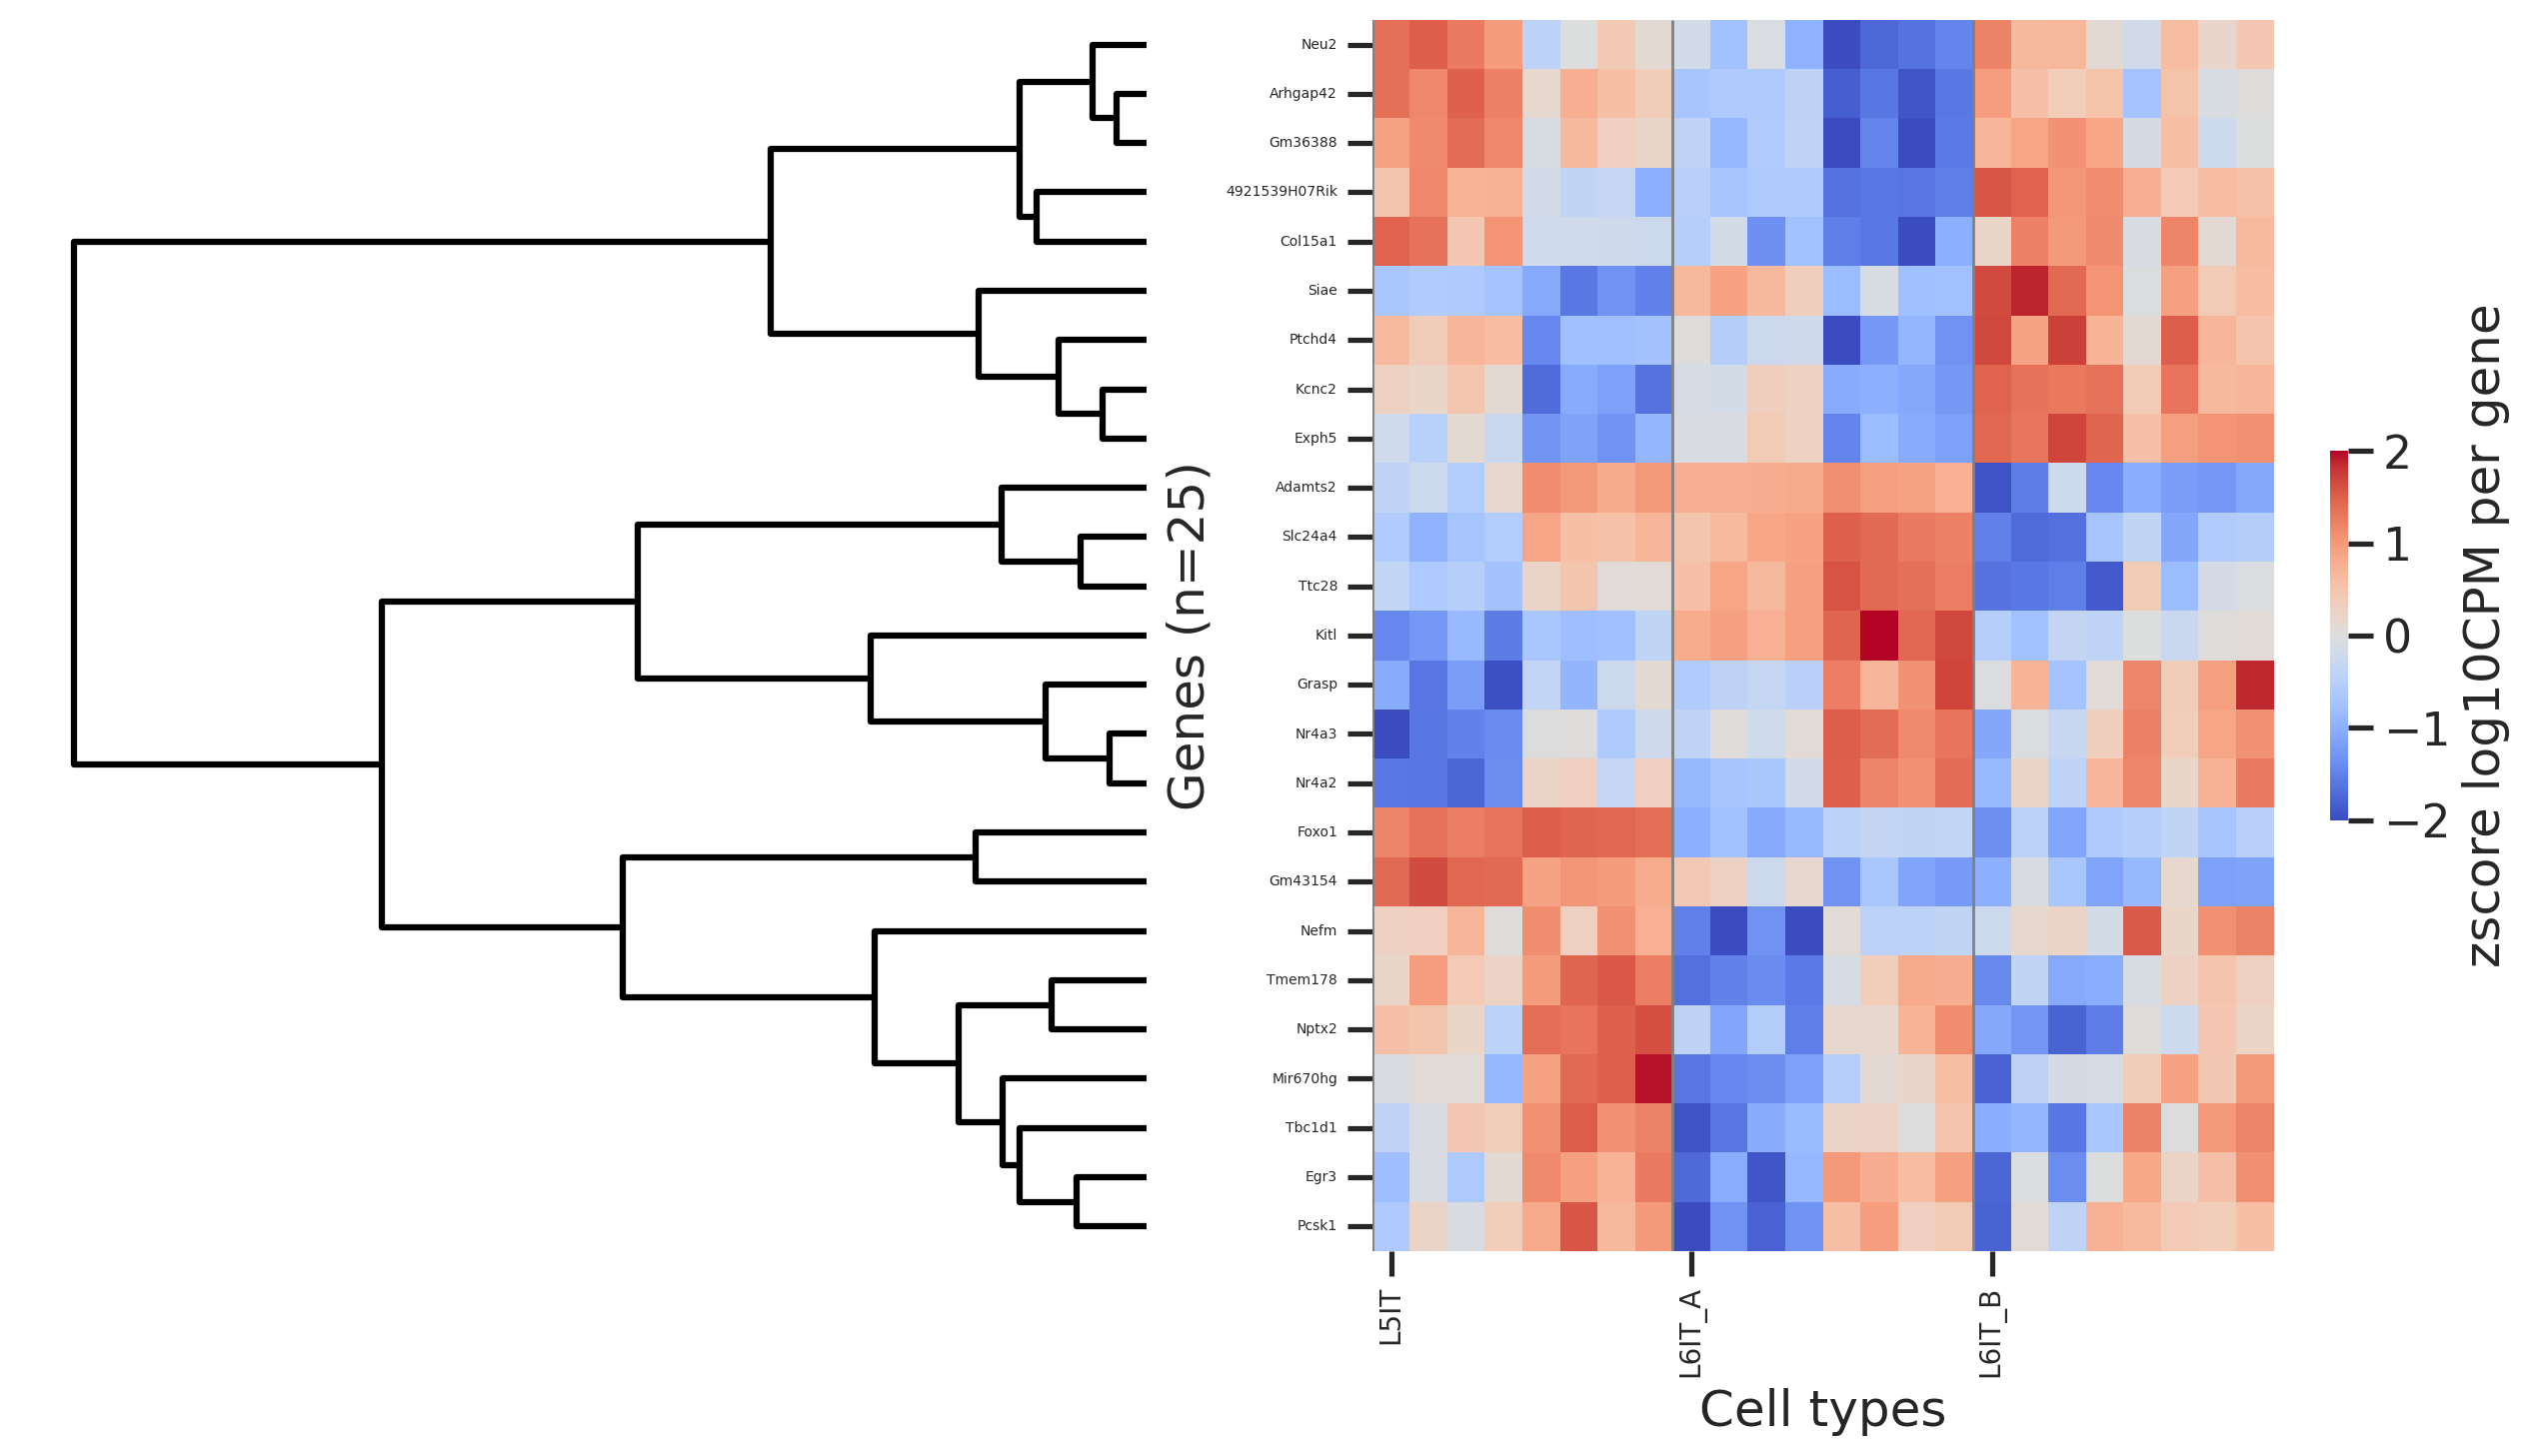

In [88]:
plotgenes = df2.loc[df2['DR_DE'], 'gene'].values
plotgenes_idx = basicu.get_index_from_array(genes, plotgenes)

row = plotgenes
col = unq_types

a = pbulks[:,:,:,plotgenes_idx].T
a = np.swapaxes(a,2,3)

plot_2panels(a, row, col)

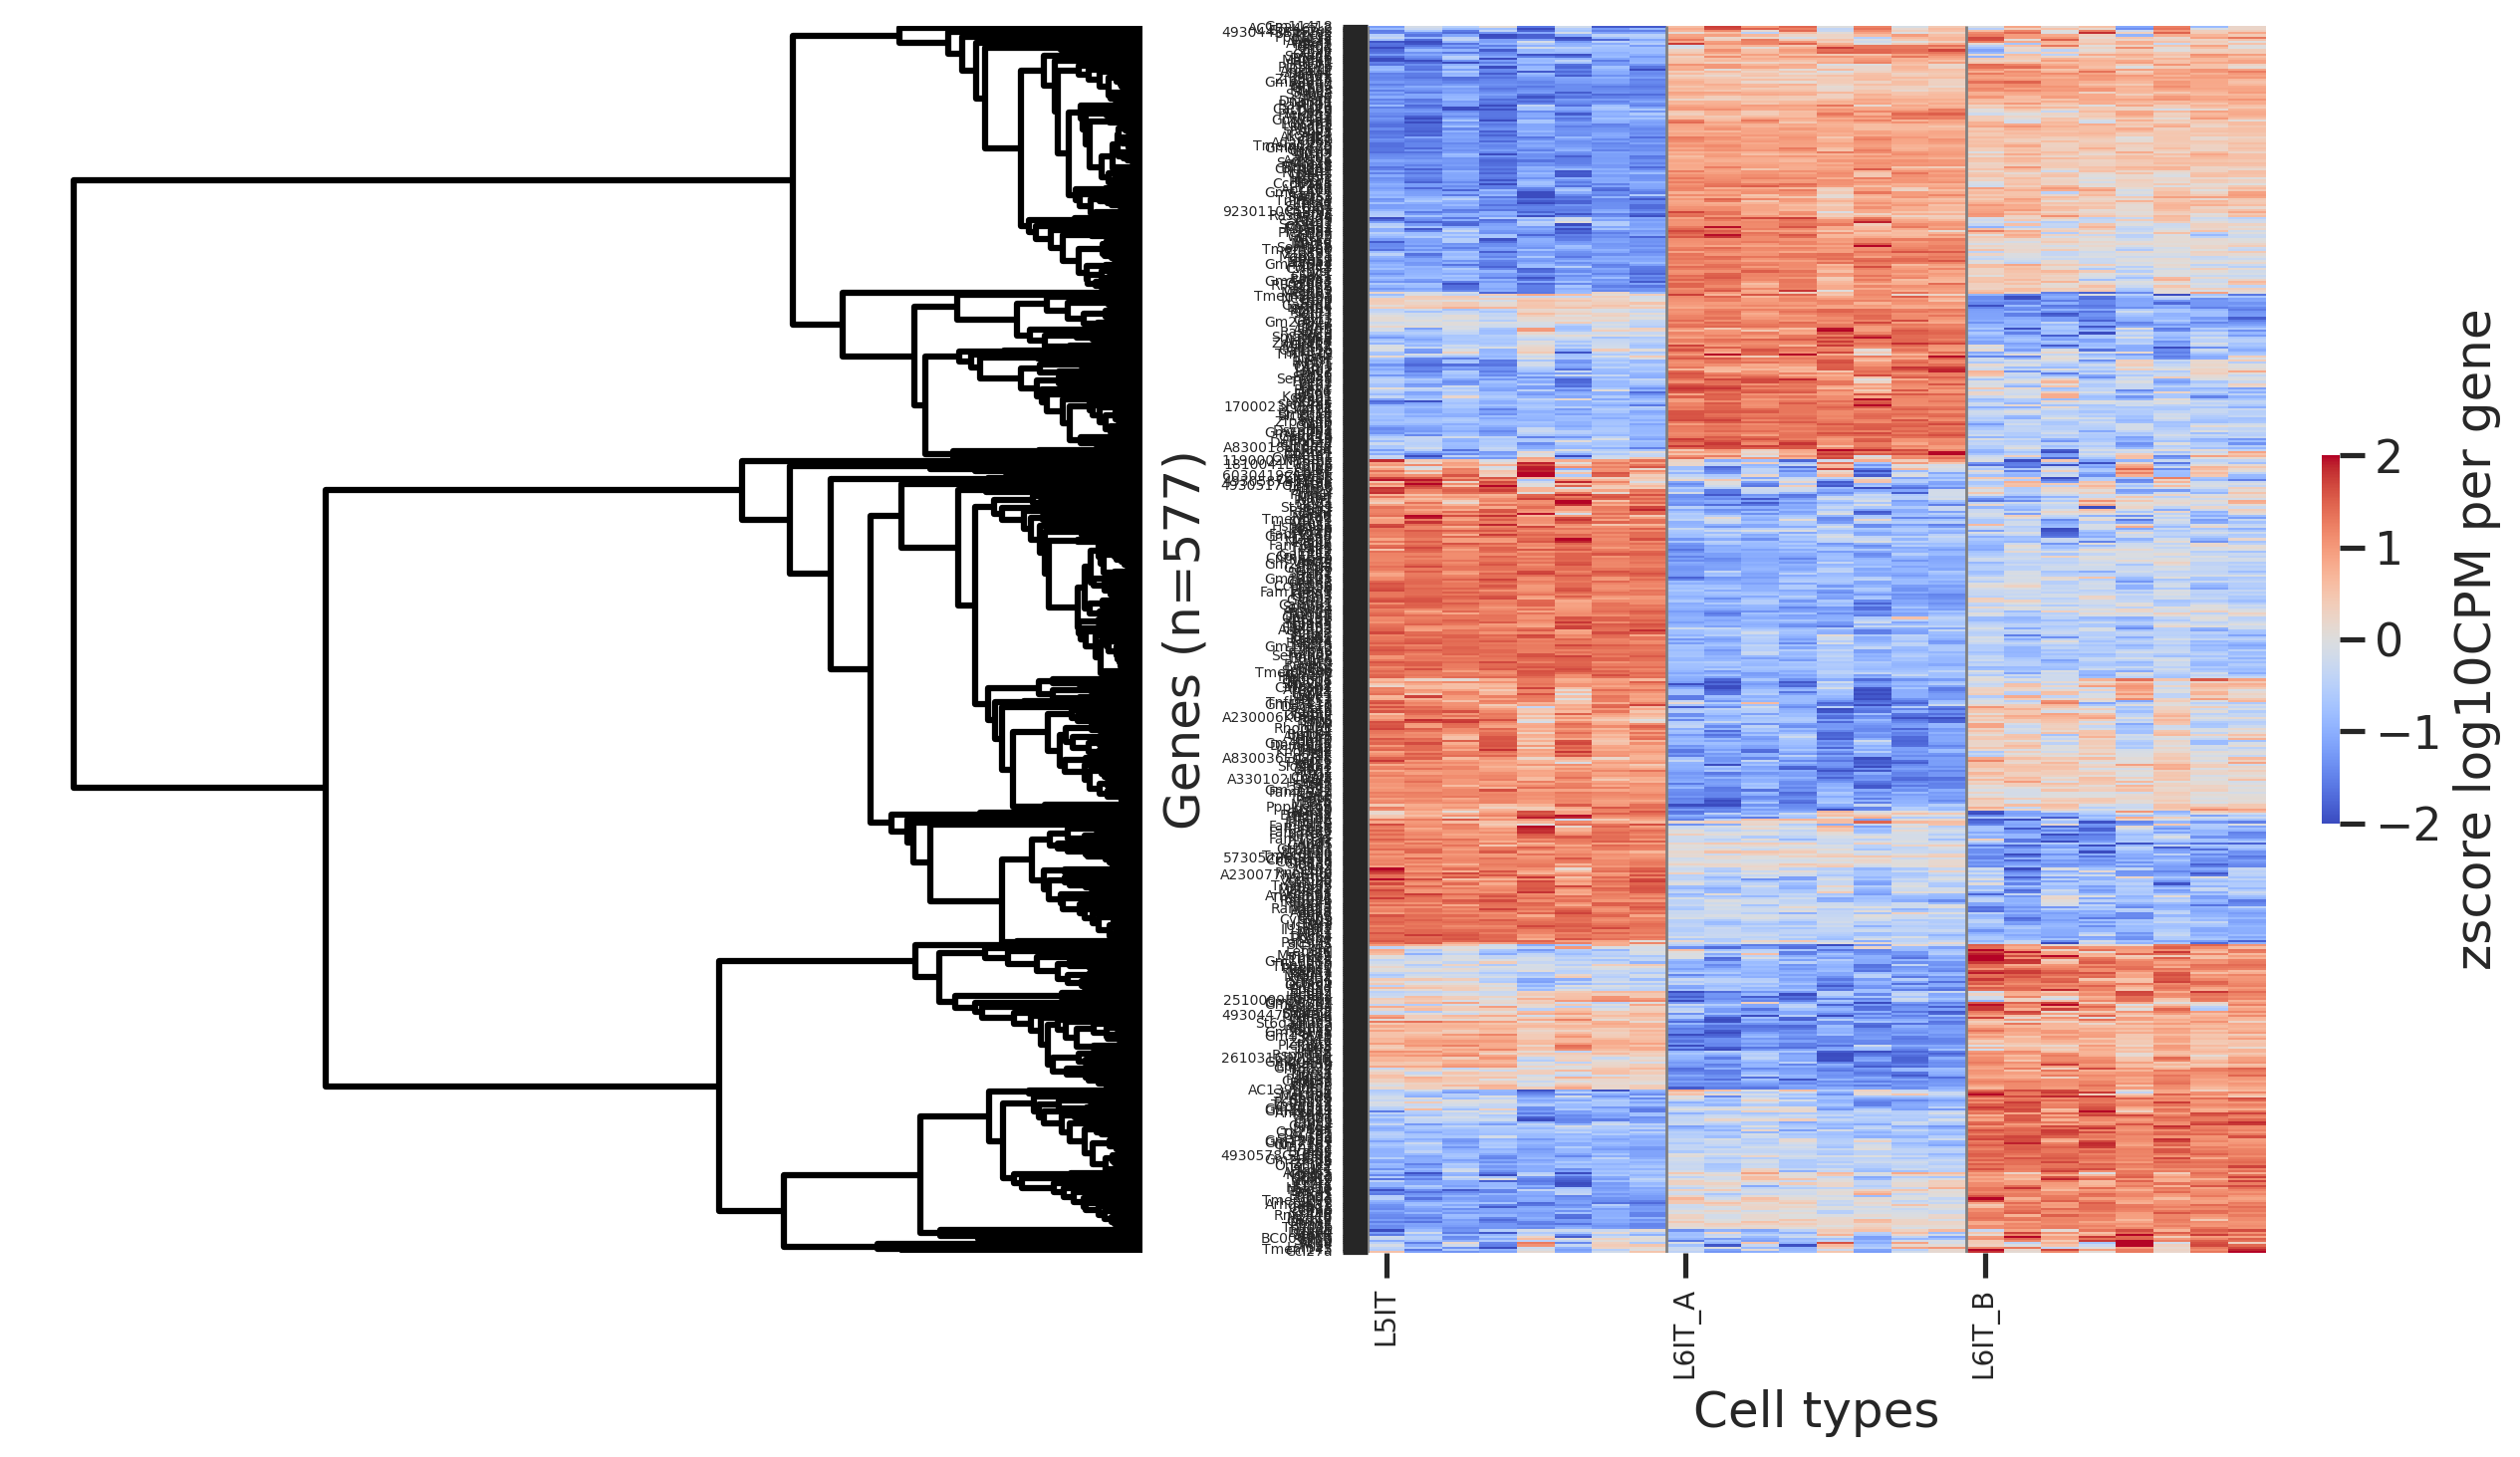

In [89]:
plotgenes = df2.loc[~df2['DR_DE'], 'gene'].values
plotgenes_idx = basicu.get_index_from_array(genes, plotgenes)

row = plotgenes
col = unq_types

a = pbulks[:,:,:,plotgenes_idx].T
a = np.swapaxes(a,2,3)

plot_2panels(a, row, col)

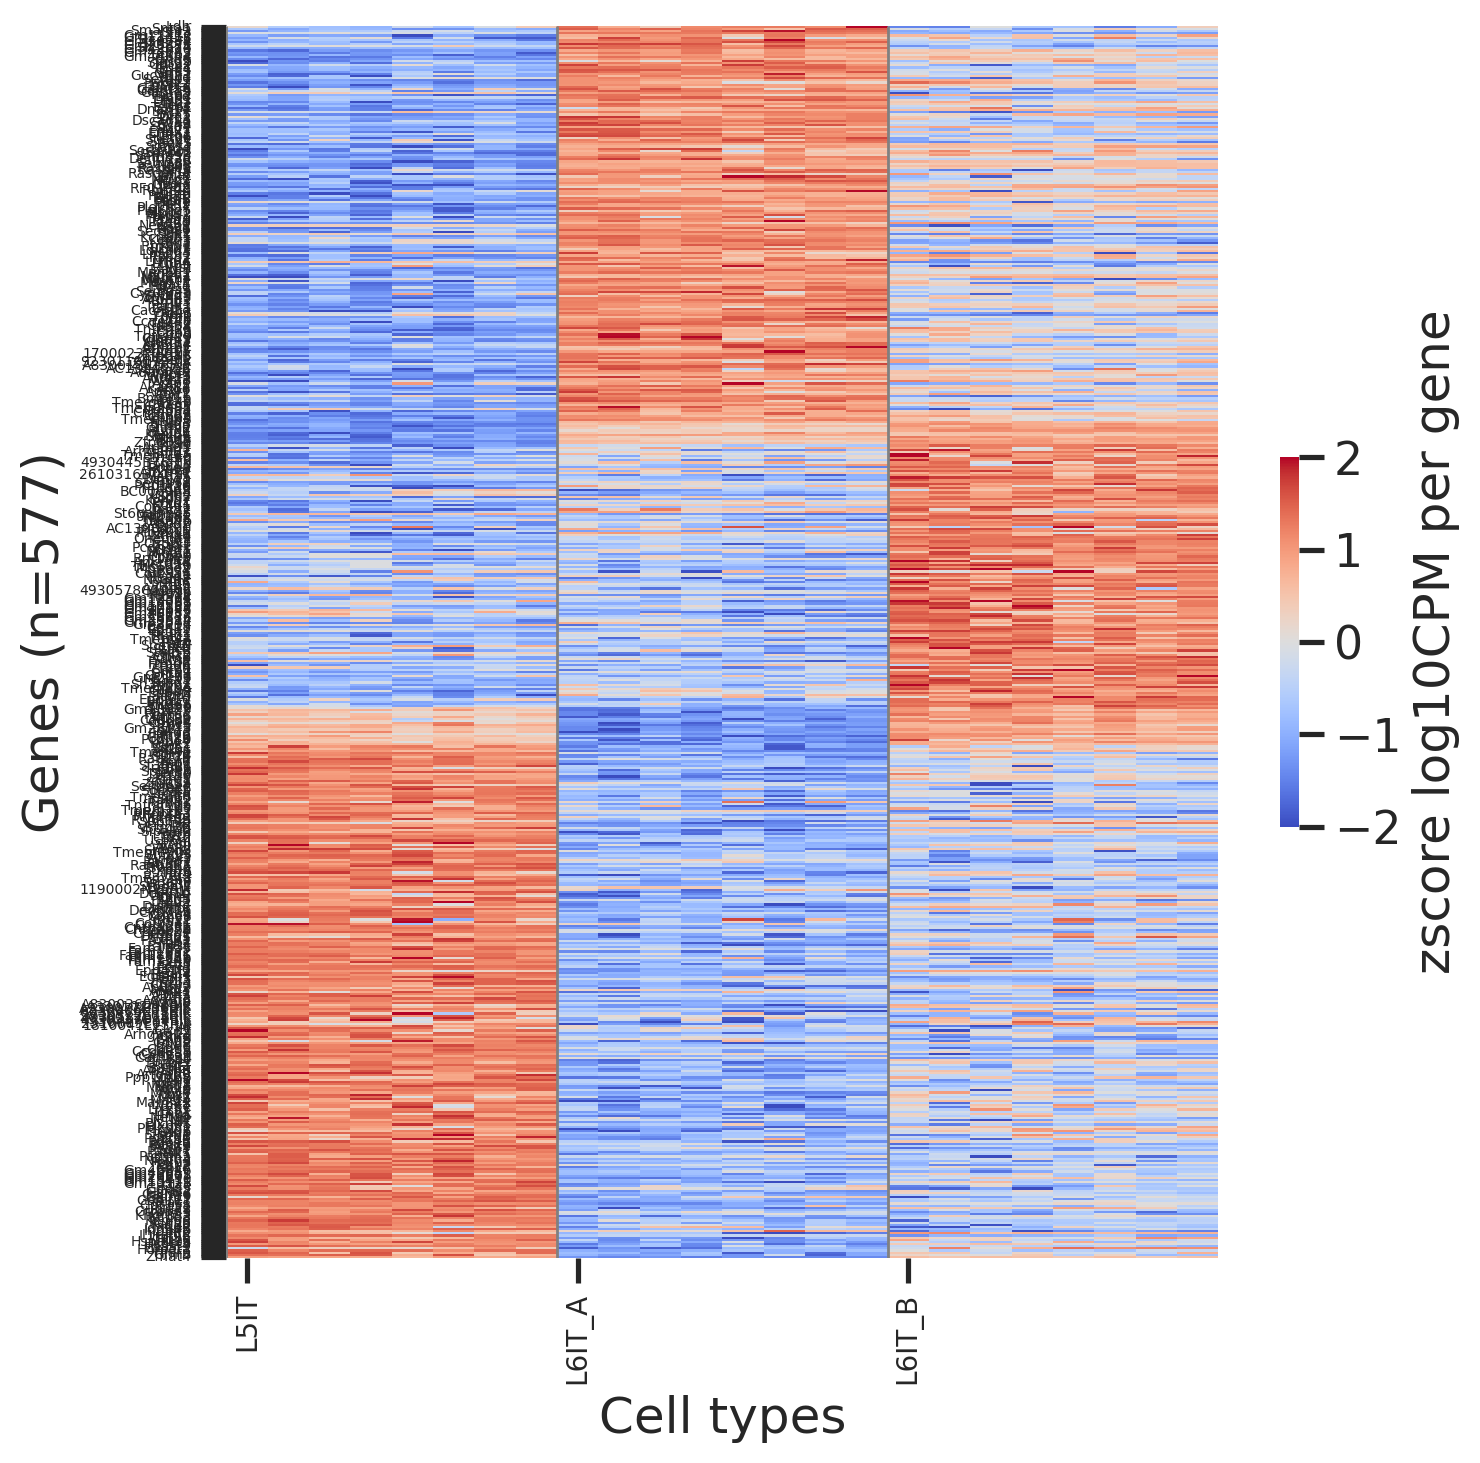

In [90]:
plotgenes = df2.loc[~df2['DR_DE'], 'gene'].values
# plotgenes = dfabc.set_index('gene').loc[plotgenes].sort_values('gene_ptime').index.values # sort
plotgenes_idx = basicu.get_index_from_array(genes, plotgenes)

row = plotgenes
col = unq_types

a = pbulks[:,:,:,plotgenes_idx].T
a = np.swapaxes(a,2,3)

plot_panels_noorder(a, row, col)

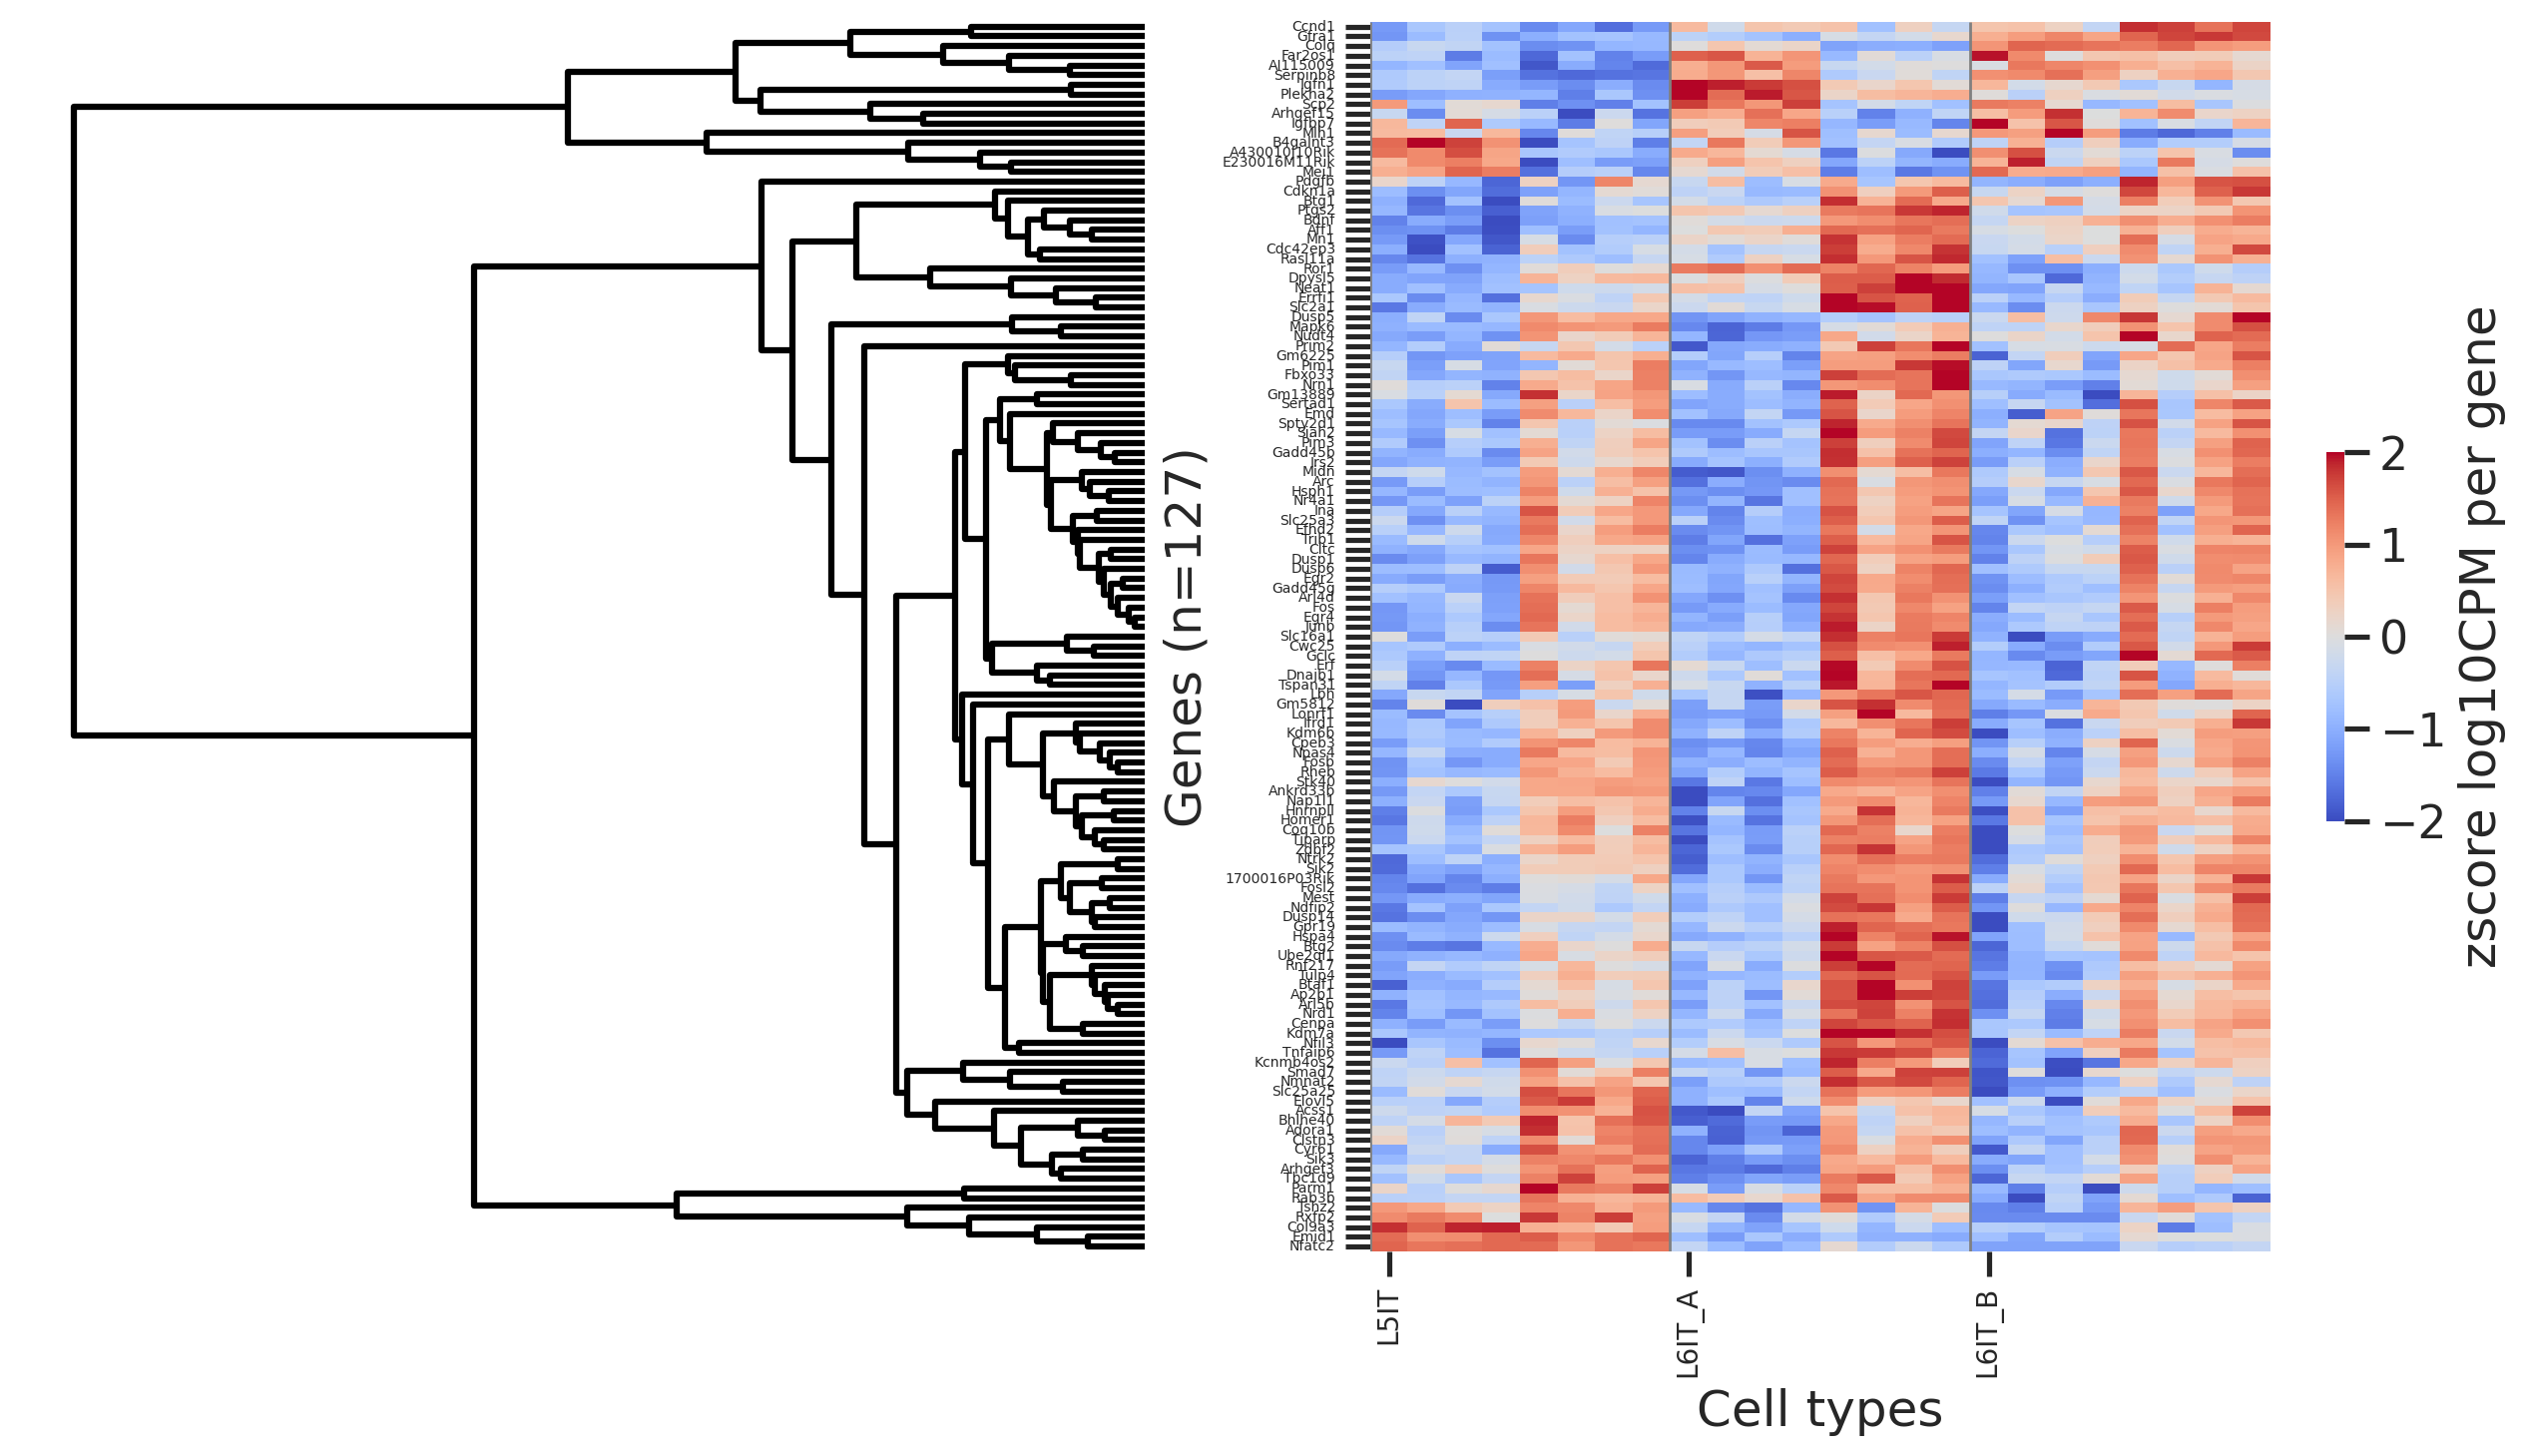

In [91]:
plotgenes = dfplot[(dfplot['isDR']) & (~dfplot['isType'])].index.values
# plotgenes = df2.loc[~df2['DR_DE'], 'gene'].values
plotgenes_idx = basicu.get_index_from_array(genes, plotgenes)

row = plotgenes
col = unq_types

a = pbulks[:,:,:,plotgenes_idx].T
a = np.swapaxes(a,2,3)

plot_2panels(a, row, col)